In [93]:
%load_ext watermark
%watermark


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-05-10T14:45:55.251172-05:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.13.2

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [94]:
import pandas as pd

import numpy as np

import seaborn as sns

from ipywidgets import interact, FloatSlider, IntSlider, fixed

from IPython.display import display

from scipy import stats
from scipy.stats import shapiro, normaltest

import pickle

import dill

from datetime import datetime

import matplotlib.pyplot as plt

import os

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.model_selection import learning_curve, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.python.platform import build_info as build
from tensorflow.keras import backend
from tensorflow.keras.optimizers import Adam, SGD

from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Dropout
from keras.callbacks import TensorBoard
from keras.constraints import maxnorm

from sklearn.datasets import load_iris

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

sns.set(font_scale=0.7)


# Description

https://www.kaggle.com/datasets/uciml/iris

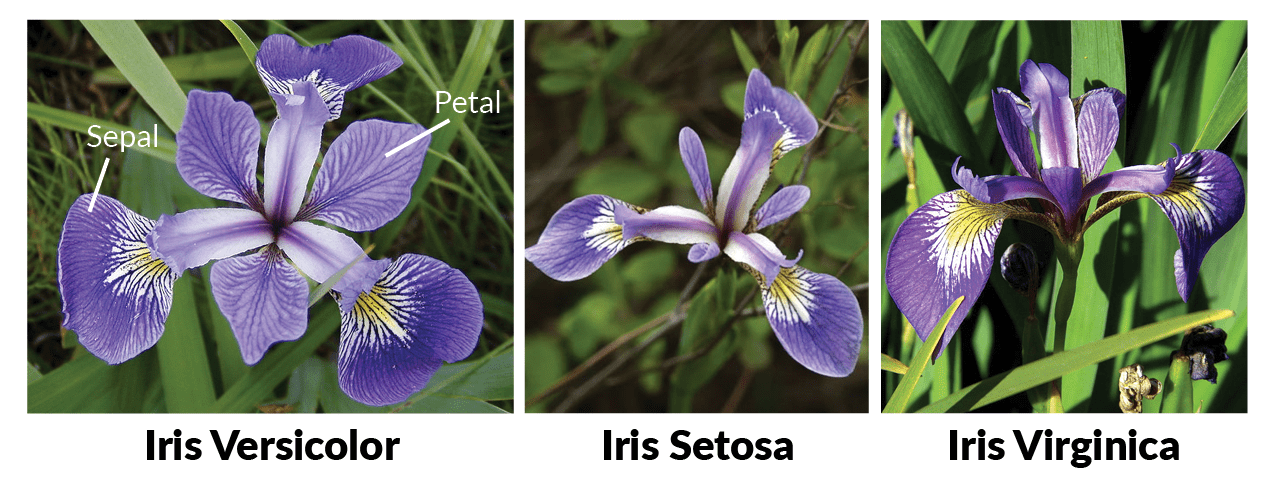

## Summary

El conjunto de datos Iris se utilizó en R.A. Fisher's classic 1936 paper, The Use of Multiple Measurements in Taxonomic Problems, y también se puede encontrar en el Repositorio de aprendizaje automático de UCI.

Incluye tres especies de iris con 50 muestras cada una, así como algunas propiedades de cada flor. Una especie de flor es linealmente separable de las otras dos, pero las otras dos no son linealmente separables entre sí.

Las columnas en este conjunto de datos son:
- Sepal Length Cm
- Sepal Width Cm
- Petal Length Cm
- Petal Width Cm
- Species

## Goal

El objetivo del notebook es diseñar un modelo que haga clasificaciones adecuadas para las flores nuevas.

Se desea obtener una buena generalización mediante el uso de diferentes técnicas de Machine Learning.

El problema será tratado como una clasificación multiclase con 4 variables independientes y 1 variable objetivo.

# Data Collection

In [95]:
iris = load_iris()
df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                  columns=iris['feature_names'] + ['target'])

df.rename(columns={"sepal length (cm)": "SEPAL_LENGHT",
                   "sepal width (cm)": "SEPAL_WIDTH",
                   "petal length (cm)": "PETAL_LENGHT",
                   "petal width (cm)": "PETAL_WIDTH",
                   "target": "TARGET"}, inplace=True)

df.head()


,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


Para convertir el dataset a un problema de clasificación binaria.

In [96]:
# binary
# multiclass
target_type = 'multiclass'

if target_type == 'binary':
    df = df[df.TARGET.isin(df.TARGET.unique()[:2])]
    iris.target_names = iris.target_names[:2]


Se eliminan los registros completamente `vacíos` y los `duplicados`.

In [97]:
n = df.shape[0]

df.dropna(axis=0, how='all', inplace=True)
df.drop_duplicates(keep='first', inplace=True)

# Eliminar por index o columnas específicas
# item_df = item_df[~item_df.index.duplicated(keep='first')]

print(f'Eliminados: {n - df.shape[0]}')
df.shape


Eliminados: 1


(149, 5)

In [98]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 149 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEPAL_LENGHT  149 non-null    float64
 1   SEPAL_WIDTH   149 non-null    float64
 2   PETAL_LENGHT  149 non-null    float64
 3   PETAL_WIDTH   149 non-null    float64
 4   TARGET        149 non-null    float64
dtypes: float64(5)
memory usage: 7.0 KB


In [99]:
df.replace(to_replace={'TARGET': {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}}, inplace=True)
df = df.astype({'TARGET': 'category'})
df.head()


,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [100]:
target_column = 'TARGET'


In [101]:
df_bk = df.copy()


# Data Transform

## Cardinality

In [102]:
cardinality_resume = pd.DataFrame(columns=['DATA_TYPE',
                                           'MORE_COMMON_VAL', 'MORE_COMMON_QTY', 'MORE_COMMON_PERC',
                                           'LESS_COMMON_VAL', 'LESS_COMMON_QTY', 'LESS_COMMON_PERC'])

for column in df.columns:
    n_per_value = df[column].value_counts(dropna=False)
    more_common_qty = n_per_value.iloc[0]
    less_common_qty = n_per_value.iloc[-1]

    cardinality_resume.loc[column] = {'DATA_TYPE': df[column].dtype,
                                      'MORE_COMMON_VAL': n_per_value.index[0],
                                      'MORE_COMMON_QTY': more_common_qty,
                                      'MORE_COMMON_PERC': round(more_common_qty * 100 / (1.0 * len(df)), 3),
                                      'LESS_COMMON_VAL': n_per_value.index[-1],
                                      'LESS_COMMON_QTY': less_common_qty,
                                      'LESS_COMMON_PERC': round(less_common_qty * 100 / (1.0 * len(df)), 3)}

cardinality_resume


,DATA_TYPE,MORE_COMMON_VAL,MORE_COMMON_QTY,MORE_COMMON_PERC,LESS_COMMON_VAL,LESS_COMMON_QTY,LESS_COMMON_PERC
SEPAL_LENGHT,float64,5.0,10,6.711,7.9,1,0.671
SEPAL_WIDTH,float64,3.0,26,17.450,2.0,1,0.671
PETAL_LENGHT,float64,1.4,13,8.725,6.4,1,0.671
PETAL_WIDTH,float64,0.2,29,19.463,0.5,1,0.671
TARGET,category,Setosa,50,33.557,Virginica,49,32.886


In [103]:
cardinality_resume = cardinality_resume.loc[(cardinality_resume.MORE_COMMON_PERC > 90.) |
                                            ((cardinality_resume.MORE_COMMON_PERC > 25.) &
                                             (cardinality_resume.MORE_COMMON_VAL.isna()))]
cardinality_resume


,DATA_TYPE,MORE_COMMON_VAL,MORE_COMMON_QTY,MORE_COMMON_PERC,LESS_COMMON_VAL,LESS_COMMON_QTY,LESS_COMMON_PERC


In [104]:
for col in cardinality_resume.index:
    display(df[col].value_counts(normalize=True, dropna=False))
    print('----------------------------------')


- No existen columnas para eliminar.

## Transformer

In [105]:
class IrisDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vif):
        self.drop_columns = []
        self.vif = vif

    # https://www.udemy.com/course/aprende-data-science-y-machine-learning-con-python/learn/lecture/8699338

    def fit(self, X, y=None):
        if self.vif == True:
            self.__vif_excec(X)

        return self

    def transform(self, X):
        X = X.drop(labels=self.drop_columns, axis=1)
        return X

    # Factor de Inflación de la Varianza
    def __vif_excec(self, X):
        features = X.select_dtypes(np.number).columns.to_list()
        # features.remove(self.target_column)
        X = X[features]

        while True:
            vif_data = self.__vif_calc(X).query('VIF >= 5').sort_values(by='VIF', ascending=False).head(1)

            if vif_data.shape[0] > 0:
                feature_vif, vif_value = vif_data.iloc[0]['FEAUTURE'], str(vif_data.iloc[0]['VIF'])

                self.drop_columns.append(feature_vif)
                X = X.drop(feature_vif, axis=1)

                print(f'Removed {feature_vif} with VIF={vif_value}.')
            else:
                break

    def __vif_calc(self, X):
        vif_data = pd.DataFrame()
        vif_data['FEAUTURE'] = X.columns

        vif_data['VIF'] = [variance_inflation_factor(exog=X.values, exog_idx=i)
                           for i, _ in enumerate(X.columns)]

        return vif_data


dill.dump(IrisDataTransformer, open('resources/data_transformer', 'wb'))

vif_transformer = False
data_transf = IrisDataTransformer(vif=vif_transformer)
df = data_transf.fit_transform(df)
df.head()


,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


# Outliers

In [106]:
def build_outliers_resume():
    resume = pd.DataFrame(columns=['OUTLIER', 'FREQUENCY', 'UNIQUE_OUTLIERS', 'UNIQUE_VALUES', 'DATA_TYPE'])
    resume.OUTLIER = resume.OUTLIER.astype(bool)

    for col in df.columns:
        try:
            df[col] = df[col].astype(float)
        except:
            continue

        # zcores absoluto de cada valor de la columna seleccionada
        zcores = np.abs(stats.zscore(df[col]))

        outliers = df[zcores > 3][col].values
        n_outliers = len(outliers)

        resume.loc[col] = {'OUTLIER': False if n_outliers == 0 else True,
                           'FREQUENCY': n_outliers,
                           'UNIQUE_OUTLIERS': set(outliers),
                           'UNIQUE_VALUES': df[col].unique(),
                           'DATA_TYPE': df[col].dtype}

    return resume


build_outliers_resume()


,OUTLIER,FREQUENCY,UNIQUE_OUTLIERS,UNIQUE_VALUES,DATA_TYPE
SEPAL_LENGHT,False,0,{},"[5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.4, 4.8, 4.3, ...",float64
SEPAL_WIDTH,True,1,{4.4},"[3.5, 3.0, 3.2, 3.1, 3.6, 3.9, 3.4, 2.9, 3.7, ...",float64
PETAL_LENGHT,False,0,{},"[1.4, 1.3, 1.5, 1.7, 1.6, 1.1, 1.2, 1.0, 1.9, ...",float64
PETAL_WIDTH,False,0,{},"[0.2, 0.4, 0.3, 0.1, 0.5, 0.6, 1.4, 1.5, 1.3, ...",float64


- Se sustituyen los outliers por NaN. 
- Las columnas `discretas` se convierte automáticamente a `continuas` ya que NaN es un valor continuo.
- Analizar detalladamente cada columna, a no todas se le aplican los cambios. 
- No se actualiza la columna objetivo.

In [107]:
class IrisOutlierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ops = ['SEPAL_LENGHT', 'SEPAL_WIDTH',
                    'PETAL_LENGHT', 'PETAL_WIDTH']

    def fit(self, X, y=None):
        self.sts = {col: {'mean': X[col].mean(), 'std': X[col].std()}
                    for col in self.ops}

        return self

    def transform(self, X):
        X = X.copy()

        for col in self.ops:
            zcores = np.abs((X[col] - self.sts[col]['mean']) / self.sts[col]['std'])
            idx = zcores[zcores > 3].index

            X.loc[idx, col] = np.nan

        # X.loc[~X[''].isin([0, 1]), ''] = None

        return X


dill.dump(IrisOutlierTransformer, open('resources/outlier_transformer', 'wb'))

outlier_transf = IrisOutlierTransformer()
df = outlier_transf.fit_transform(df)
df.head()


,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [108]:
build_outliers_resume()


,OUTLIER,FREQUENCY,UNIQUE_OUTLIERS,UNIQUE_VALUES,DATA_TYPE
SEPAL_LENGHT,False,0,{},"[5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.4, 4.8, 4.3, ...",float64
SEPAL_WIDTH,False,0,{},"[3.5, 3.0, 3.2, 3.1, 3.6, 3.9, 3.4, 2.9, 3.7, ...",float64
PETAL_LENGHT,False,0,{},"[1.4, 1.3, 1.5, 1.7, 1.6, 1.1, 1.2, 1.0, 1.9, ...",float64
PETAL_WIDTH,False,0,{},"[0.2, 0.4, 0.3, 0.1, 0.5, 0.6, 1.4, 1.5, 1.3, ...",float64


# Imputers

In [109]:
def build_imputers_resume():
    resume = pd.DataFrame()

    for column in df.columns:
        resume.loc[column, 'TYPE'] = df[column].dtype
        resume.loc[column, 'VALUES'] = str(df[column].unique())
        resume.loc[column, 'VALUES_LEN'] = len(df[column].unique())
        resume.loc[column, 'NULL_COUNT'] = df[column].isnull().sum(axis=0)

    return resume


build_imputers_resume()


,TYPE,VALUES,VALUES_LEN,NULL_COUNT
SEPAL_LENGHT,float64,[5.1 4.9 4.7 4.6 5. 5.4 4.4 4.8 4.3 5.8 5.7 5...,35.0,0.0
SEPAL_WIDTH,float64,[3.5 3. 3.2 3.1 3.6 3.9 3.4 2.9 3.7 4. nan 3...,23.0,1.0
PETAL_LENGHT,float64,[1.4 1.3 1.5 1.7 1.6 1.1 1.2 1. 1.9 4.7 4.5 4...,43.0,0.0
PETAL_WIDTH,float64,[0.2 0.4 0.3 0.1 0.5 0.6 1.4 1.5 1.3 1.6 1. 1...,22.0,0.0
TARGET,category,"['Setosa', 'Versicolor', 'Virginica']\nCategor...",3.0,0.0


Se eliminan los registros de las columnas que no tienen sentidos `imputarlas` (`variable objetivo`, etc).

In [110]:
idx = df[df[target_column].isna()].index

df.drop(axis=0, index=idx, inplace=True)
df_bk.drop(axis=0, index=idx, inplace=True)


In [111]:
class IrisImputeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.ops = {'SEPAL_LENGHT': X['SEPAL_LENGHT'].median(),
                    'SEPAL_WIDTH': X['SEPAL_WIDTH'].median(),
                    'PETAL_LENGHT': X['PETAL_LENGHT'].median(),
                    'PETAL_WIDTH': X['PETAL_WIDTH'].median()}

        return self

    def transform(self, X):
        X = X.copy()

        for k in self.ops:
            X[k].fillna(value=self.ops[k], inplace=True)

        return X


dill.dump(IrisImputeTransformer, open('resources/impute_transformer', 'wb'))

impute_transf = IrisImputeTransformer()
df = impute_transf.fit_transform(df)
df.head()


,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [112]:
build_imputers_resume()


,TYPE,VALUES,VALUES_LEN,NULL_COUNT
SEPAL_LENGHT,float64,[5.1 4.9 4.7 4.6 5. 5.4 4.4 4.8 4.3 5.8 5.7 5...,35.0,0.0
SEPAL_WIDTH,float64,[3.5 3. 3.2 3.1 3.6 3.9 3.4 2.9 3.7 4. 3.8 3...,22.0,0.0
PETAL_LENGHT,float64,[1.4 1.3 1.5 1.7 1.6 1.1 1.2 1. 1.9 4.7 4.5 4...,43.0,0.0
PETAL_WIDTH,float64,[0.2 0.4 0.3 0.1 0.5 0.6 1.4 1.5 1.3 1.6 1. 1...,22.0,0.0
TARGET,category,"['Setosa', 'Versicolor', 'Virginica']\nCategor...",3.0,0.0


# Exploratory Data Analysis (EDA)

### Data Types

In [113]:
type_resume = pd.DataFrame()

for column in df.columns:
    type_resume.loc[column, 'TYPE'] = df[column].dtype
    type_resume.loc[column, 'VALUES'] = str(df[column].unique())
    type_resume.loc[column, 'VALUES_LEN'] = len(df[column].unique())

type_resume


,TYPE,VALUES,VALUES_LEN
SEPAL_LENGHT,float64,[5.1 4.9 4.7 4.6 5. 5.4 4.4 4.8 4.3 5.8 5.7 5...,35.0
SEPAL_WIDTH,float64,[3.5 3. 3.2 3.1 3.6 3.9 3.4 2.9 3.7 4. 3.8 3...,22.0
PETAL_LENGHT,float64,[1.4 1.3 1.5 1.7 1.6 1.1 1.2 1. 1.9 4.7 4.5 4...,43.0
PETAL_WIDTH,float64,[0.2 0.4 0.3 0.1 0.5 0.6 1.4 1.5 1.3 1.6 1. 1...,22.0
TARGET,category,"['Setosa', 'Versicolor', 'Virginica']\nCategor...",3.0


In [114]:
#

df.dtypes


SEPAL_LENGHT     float64
SEPAL_WIDTH      float64
PETAL_LENGHT     float64
PETAL_WIDTH      float64
TARGET          category
dtype: object

### Data Binning

Se crean variables categóricas auxiliares a partir de las variables numéricas.

We have 2 options to group the values.
- cut: The space between the groups are equal and the frequencies of each group are different.
- qcut: The space between the groups are different and the frequencies of each group are equal.

To make containers with very different data less likely we use qcut.

In [115]:
desc_resume = pd.DataFrame()

for column in set(df.select_dtypes(include=np.number).columns) - {''}:
    desc_resume.loc[column, 'TYPE'] = df[column].dtype
    desc_resume.loc[column, 'VALUES'] = str(df[column].unique())
    desc_resume.loc[column, 'VALUES_LEN'] = len(df[column].unique())
    desc_resume.loc[column, 'MIN'] = df[column].min()
    desc_resume.loc[column, 'MAX'] = df[column].max()

desc_resume


,TYPE,VALUES,VALUES_LEN,MIN,MAX
SEPAL_WIDTH,float64,[3.5 3. 3.2 3.1 3.6 3.9 3.4 2.9 3.7 4. 3.8 3...,22.0,2.0,4.2
SEPAL_LENGHT,float64,[5.1 4.9 4.7 4.6 5. 5.4 4.4 4.8 4.3 5.8 5.7 5...,35.0,4.3,7.9
PETAL_WIDTH,float64,[0.2 0.4 0.3 0.1 0.5 0.6 1.4 1.5 1.3 1.6 1. 1...,22.0,0.1,2.5
PETAL_LENGHT,float64,[1.4 1.3 1.5 1.7 1.6 1.1 1.2 1. 1.9 4.7 4.5 4...,43.0,1.0,6.9


In [116]:
@interact
def my_boxplot(col=desc_resume.index):
    plt.rcParams['figure.figsize'] = (10, 2)

    sns.boxplot(data=df, x=col)

    plt.title('Box Plot', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.show()


interactive(children=(Dropdown(description='col', options=('SEPAL_WIDTH', 'SEPAL_LENGHT', 'PETAL_WIDTH', 'PETA…

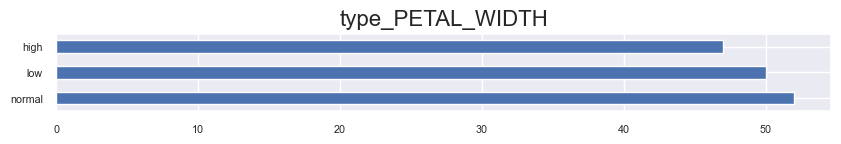

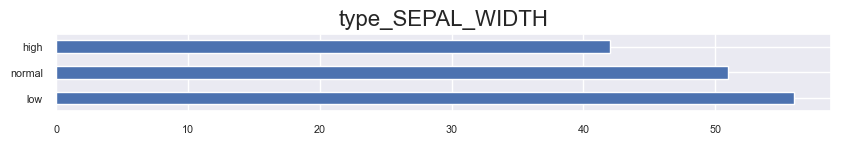

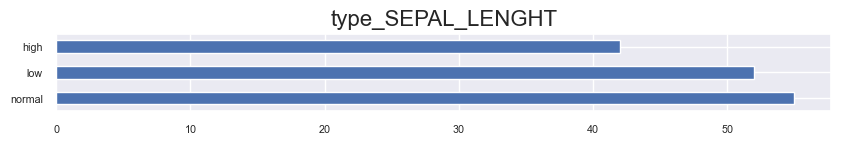

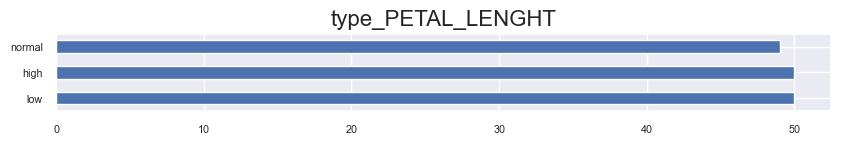

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET,type_PETAL_WIDTH,type_SEPAL_WIDTH,type_SEPAL_LENGHT,type_PETAL_LENGHT
0,5.1,3.5,1.4,0.2,Setosa,low,high,low,low
1,4.9,3.0,1.4,0.2,Setosa,low,normal,low,low
2,4.7,3.2,1.3,0.2,Setosa,low,normal,low,low
3,4.6,3.1,1.5,0.2,Setosa,low,normal,low,low
4,5.0,3.6,1.4,0.2,Setosa,low,high,low,low


In [117]:
# Si no existe una clasificación brindada por el negocio, se realiza una agrupación natural (qcut-cut).
# Ejemplo:
#  Edad: [0-7): niño, [8-18): adolescente, [70-120]: 3ra edad


types_2 = ['low', 'high']
types_3 = ['low', 'normal', 'high']
types_5 = ['very low', 'low', 'moderate', 'high', 'very high']

pref = 'type_'  # Para optimizar los gráficos que de generarán a continuación.

# Columns created are added to delete later.
type_columns = [
    (f'{pref}PETAL_WIDTH', 'PETAL_WIDTH', types_3),
    (f'{pref}SEPAL_WIDTH', 'SEPAL_WIDTH', types_3),
    (f'{pref}SEPAL_LENGHT', 'SEPAL_LENGHT', types_3),
    (f'{pref}PETAL_LENGHT', 'PETAL_LENGHT', types_3)]

for col in type_columns:
    plt.rcParams['figure.figsize'] = (10, len(col[2])/3)

    df[col[0]] = pd.qcut(x=df[col[1]], q=len(col[2]), labels=col[2])
#     df[col[0]] = pd.cut(x=df[col[1]], bins=len(col[2]), labels=col[2])

    df[col[0]].value_counts().plot(kind='barh')

    plt.title(col[0], fontsize=16)
    plt.ylabel('')
    plt.show()

df.head()


In [118]:
date_columns = []

for col in df.select_dtypes(include=np.datetime64).columns:
    dw, d, m = f'{col}_day_of_week', f'{col}_day', f'{col}_month'
    date_columns = date_columns + [dw, d, m]

    df[dw] = pd.DatetimeIndex(df[col]).dayofweek.astype('category')
    df[d] = pd.DatetimeIndex(df[col]).day.astype('category')
    df[m] = pd.DatetimeIndex(df[col]).month.astype('category')

df.head()


,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET,type_PETAL_WIDTH,type_SEPAL_WIDTH,type_SEPAL_LENGHT,type_PETAL_LENGHT
0,5.1,3.5,1.4,0.2,Setosa,low,high,low,low
1,4.9,3.0,1.4,0.2,Setosa,low,normal,low,low
2,4.7,3.2,1.3,0.2,Setosa,low,normal,low,low
3,4.6,3.1,1.5,0.2,Setosa,low,normal,low,low
4,5.0,3.6,1.4,0.2,Setosa,low,high,low,low


In [119]:
numeric_features = df.select_dtypes(np.number).columns.to_list()
continuous_features = df.select_dtypes(float).columns.to_list()
discrete_features = df.select_dtypes(int).columns.to_list()
categorical_features = df.select_dtypes('category').columns.to_list()
object_features = df.select_dtypes('object').columns.to_list()
bool_features = df.select_dtypes(bool).columns.to_list()
date_time_features = df.select_dtypes(np.datetime64).columns.to_list()
time_delta_features = df.select_dtypes(np.timedelta64).columns.to_list()

display({'numeric_features': ', '.join(numeric_features), 'continuous_features': ', '.join(continuous_features),
         'discrete_features': ', '.join(discrete_features), 'categorical_features': ', '.join(categorical_features),
         'object_features': ', '.join(object_features), 'bool_features': ', '.join(bool_features),
         'date_time_features': ', '.join(date_time_features), 'time_delta_features': ', '.join(time_delta_features)})


{'numeric_features': 'SEPAL_LENGHT, SEPAL_WIDTH, PETAL_LENGHT, PETAL_WIDTH',
 'continuous_features': 'SEPAL_LENGHT, SEPAL_WIDTH, PETAL_LENGHT, PETAL_WIDTH',
 'discrete_features': '',
 'categorical_features': 'TARGET, type_PETAL_WIDTH, type_SEPAL_WIDTH, type_SEPAL_LENGHT, type_PETAL_LENGHT',
 'object_features': '',
 'bool_features': '',
 'date_time_features': '',
 'time_delta_features': ''}

## Statistical Summary

In [120]:
df.describe()


,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH
count,149.000000,149.000000,149.000000,149.000000
mean,5.843624,3.050336,3.748993,1.194631
std,0.830851,0.422128,1.767791,0.762622
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.300000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.200000,6.900000,2.500000


## Correlation

### Dispersion Diagram

In [121]:
@interact
def _(hue=[None] + categorical_features + bool_features,
      n_samples=IntSlider(value=len(df), min=len(df), max=len(df), step=1000)):

    if hue != None and len(df[hue].unique()) > 20:
        print(f'Too many categories: {hue}={df[hue].unique()}')
        return

    _df = df.sample(n=n_samples, replace=False, random_state=23)

    sns.pairplot(data=_df, hue=hue, diag_kind='hist')

    plt.title('Dispersion Diagram', fontsize=16)
    plt.show()


interactive(children=(Dropdown(description='hue', options=(None, 'TARGET', 'type_PETAL_WIDTH', 'type_SEPAL_WID…

In [122]:
@interact
def my_relplot(x=numeric_features,
               y=numeric_features,
               hue=[None] + categorical_features + bool_features,
               size=[None] + numeric_features,
               style=[None] + categorical_features + bool_features,
               alpha=FloatSlider(value=1, min=.1, max=1, step=.1),
               show=fixed(True), file_name=fixed('')):

    if hue != None and len(df[hue].unique()) > 50:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    if style != None and len(df[style].unique()) > 50:
        if show == True:
            print(f'Too many categories: {style}={df[style].unique()}')

        return

    chart = sns.relplot(data=df, x=x, y=y, hue=hue, size=size, style=style, alpha=alpha, height=6)

    plt.title(f'{x} vs {y}', fontsize=16)
    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='x', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PETAL…

In [123]:
@interact
def my_swarmplot(x=numeric_features,
                 y=categorical_features + bool_features,
                 hue=[None] + categorical_features + bool_features,
                 orient=['v', 'h'],
                 n_samples=IntSlider(value=len(df), min=len(df), max=len(df), step=1000),
                 show=fixed(True), file_name=fixed('')):

    plt.rcParams['figure.figsize'] = (12, 6)

    if y == None:
        print('No existen variables categóricas o booleanas.')
        return

    if len(df[y].unique()) > 50:
        if show == True:
            print(f'Too many categories: {y}={df[y].unique()}')

        return

    if hue != None and len(df[hue].unique()) > 50:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    _df = df.sample(n=n_samples, replace=True, random_state=23)

    if orient == 'v':
        x, y = y, x

    chart = sns.swarmplot(data=_df, x=x, y=y, hue=hue, orient=orient, size=3)

    plt.title(f'{y} by {x}', fontsize=16)
    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='x', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PETAL…

### Pearson Correlation

In [124]:
@interact
def my_pearson(show=fixed(True), file_name=fixed('')):

    plt.rcParams['figure.figsize'] = (5, 5)

    matrix = df.corr(method='pearson', numeric_only=True)
    chart = sns.heatmap(data=matrix, annot=True, square=True, center=0)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.title('Pearson Diagram', fontsize=16)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Output(),), _dom_classes=('widget-interact',))

## Distributions

### Histogram

In [125]:
@interact
def my_histplot(col=numeric_features,
                normal=False,
                stat=['count', 'frequency', 'probability', 'percent', 'density'],
                cumulative=False,
                hue=[None] + categorical_features + bool_features,
                kde=False,
                show=fixed(True), file_name=fixed('')):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, .3]})

    # ax1 -----------------------------------------------------------------------------------

    if normal == False:
        if hue != None and len(df[hue].unique()) > 50:
            if show == True:
                print(f'Too many categories: {hue}={df[hue].unique()}')

            plt.close()
            return

        chart = sns.histplot(data=df, ax=ax[0], x=col, hue=hue, stat=stat,
                             multiple='stack', cumulative=cumulative, kde=kde)
        chart.set(title='Histogram')
    else:
        try:
            # Valores de la media (mu) y desviación típica (sigma) de los datos
            mu, sigma = stats.norm.fit(data=df[col])

            chart = sns.histplot(data=df, ax=ax[0], x=col, stat='density')

            # Valores teóricos de la normal en el rango observado
            x_hat = np.linspace(min(df[col]), max(df[col]), num=100)
            y_hat = stats.norm.pdf(x_hat, mu, sigma)

            ax[0].plot(x_hat, y_hat, 'r', linewidth=2, label='normal')
            ax[0].legend()
        except Exception as e:
            chart = sns.histplot(data=df, ax=ax[0], x=col, stat=stat)
            print('ax_0 error:', e)
        finally:
            chart.set(title='Histogram')

    # ax2 -----------------------------------------------------------------------------------

    try:
        fig = sm.qqplot(df[col], fit=True, line='q', alpha=0.4, lw=2, ax=ax[1])
    except Exception as e:
        print('ax_1 error:', e)

    # ---------------------------------------------------------------------------------------

    if show == False:
        chart.get_figure().savefig(f'resources/EDA/{file_name}.png')
        plt.close()
        return

    kurtosis, skew = stats.kurtosis(df[col]), stats.skew(df[col])
    kurtosis, skew = round(kurtosis, 2), round(skew, 2)

    if skew < -1 or skew > 1:
        print(f'- La distribución está muy sesgada (skew={skew}).')
    elif -1 <= skew < -0.5 or 0.5 < skew <= 1:
        print(f'- La distribución está moderadamente sesgada (skew={skew}).')
    elif -0.5 <= skew <= 0.5:
        print(f'- La distribución es aproximadamente simétrica (skew={skew}).')

    if kurtosis < -0.5:
        print(f'- La distribución platicúrtica (kurtosis={kurtosis}), ', end='')
        print('existe una baja concentración de los valores en torno a su media.')
    if kurtosis > 0.5:
        print(f'- La distribución leptocúrtica (kurtosis={kurtosis}) ', end='')
        print('existe una gran concentración de los valores en torno a su media.')
    if -0.5 <= kurtosis <= 0.5:
        print(f'- La distribución mesocúrtica (kurtosis={kurtosis}) ', end='')
        print('existe una concentración normal de los valores en torno a su media.')

    plt.show()


interactive(children=(Dropdown(description='col', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PET…

### Probability Mass Function (PMF)

In [126]:
@interact
def _(column=discrete_features, normalize=False):

    if column == None:
        print('No existen variables discretas.')
        return

    plt.rcParams['figure.figsize'] = (10, 6)

    data = df[column].value_counts(normalize=normalize)

    data = pd.DataFrame({'INDEX': data.index, 'VALUE': data.values}).sort_values(by=['INDEX'])

    plt.plot(data['INDEX'], data['VALUE'], '--')
    plt.vlines(data['INDEX'], 0, data['VALUE'], colors='b', lw=5, alpha=0.5)

    plt.title('Función de Masa de Probabilidad', fontsize=16)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Density' if normalize else 'Count', fontsize=12)
    plt.show()


interactive(children=(Dropdown(description='column', options=(), value=None), Checkbox(value=False, descriptio…

In [127]:
@interact
def _(x=numeric_features,
      y=numeric_features,
      hue=[None] + categorical_features + bool_features,
      kind=['scatter', 'kde', 'hist', 'hex', 'reg', 'resid'],
      show=fixed(True), file_name=fixed('')):

    if hue != None and len(df[hue].unique()) > 50:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    chart = sns.jointplot(data=df, x=x, y=y, hue=hue, kind=kind, height=6)

    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='x', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PETAL…

### Box - Violin Plot

In [128]:
@interact
def my_boxplot(col=[None] + numeric_features,
               violin=False,
               orient=['v', 'h'],
               show=fixed(True), file_name=fixed('')):

    plt.rcParams['figure.figsize'] = (12, 8) if col is None else (8, 2)

    if violin:
        chart = sns.violinplot(data=df, x=col, orient=orient)
        plt.title('Violin Plot', fontsize=16)
    else:
        chart = sns.boxplot(data=df, x=col, orient=orient)
        plt.title('Box Plot', fontsize=16)

    plt.xlabel(col, fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='col', options=(None, 'SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT'…

In [129]:
@interact
def my_violinplot(x=categorical_features + bool_features,
                  y=numeric_features,
                  hue=[None] + bool_features,
                  violin=False,
                  split=False,
                  orient=['v', 'h'],
                  show_points=False,
                  show=fixed(True), file_name=fixed('')):

    if x == None:
        print('No existen variables categóricas o booleanas.')
        return

    if len(df[x].unique()) > 50:
        if show == True:
            print(f'Too many categories: {x}={df[x].unique()}')

        return

    x_org = x
    if orient == 'h':
        x, y = y, x

    if show_points == True:
        chart = sns.stripplot(data=df, x=x, y=y, color='.3', size=3)

    plt.rcParams['figure.figsize'] = (10, 6)

    if violin:
        chart = sns.violinplot(x=x, y=y, data=df, hue=hue, split=split, orient=orient)
        plt.title(f'Violin Plot by {x_org}', fontsize=16)
    else:
        chart = sns.boxplot(x=x, y=y, data=df, hue=hue, orient=orient)
        plt.title(f'Box Plot by {x_org}', fontsize=16)

    sns.despine(offset=10, trim=True)

    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='x', options=('TARGET', 'type_PETAL_WIDTH', 'type_SEPAL_WIDTH', 'ty…

## Contingency Table

In [130]:
@interact
def my_contingency(index=categorical_features + bool_features,
                   column=categorical_features + bool_features,
                   values=numeric_features,
                   annot=True,
                   agg_func=['count', 'mean', 'median', 'sum', 'std', 'probability'],
                   show=fixed(True), file_name=fixed('')):

    plt.rcParams['figure.figsize'] = (8, 8)

    if index == None:
        print('No existen variables categóricas.')
        return

    if index == column:
        sns.displot(data=df, x=index)

        plt.title('Contingency Table', fontsize=16)
        plt.xlabel(index, fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.show()

        return

    if len(df[index].unique()) > 50:
        if show == True:
            print(f'Too many categories: {index}={df[index].unique()}')

        return

    if len(df[column].unique()) > 50:
        if show == True:
            print(f'Too many categories: {column}={df[column].unique()}')

        return

    agg_func_aux = 'count' if agg_func == 'probability' else agg_func
    contingency_table = df.pivot_table(index=index, columns=column, values=values,
                                       aggfunc=agg_func_aux, fill_value=0).dropna(axis=0, how='all')

#     display(contingency_table)

    if agg_func == 'probability':
        contingency_table = contingency_table.astype(float).div(contingency_table.sum(axis=1), axis=0)
        fmt = '.2%'
    else:
        fmt = 'g'

    chart = sns.heatmap(data=contingency_table, annot=annot, fmt=fmt, square=True)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

    if agg_func == 'count':
        plt.title(f'Contingency Table ({agg_func})', fontsize=16)
    else:
        plt.title(f'Contingency Table ({agg_func} {values})', fontsize=16)

    plt.xlabel(column, fontsize=12)
    plt.ylabel(index, fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='index', options=('TARGET', 'type_PETAL_WIDTH', 'type_SEPAL_WIDTH',…

## Statistics

In [131]:
@interact
def my_catplot(x=categorical_features + bool_features,
               y=numeric_features,
               hue=[None] + categorical_features + bool_features,
               estimator=['mean', 'count', 'median', 'sum', 'std'],
               kind=['bar', 'strip', 'box', 'violin', 'boxen', 'point'],
               orient=['v', 'h'],
               show=fixed(True), file_name=fixed('')):

    if x == None:
        print('No existen variables categóricas.')
        return

    if len(df[x].unique()) > 50:
        if show == True:
            print(f'Too many categories: {x}={df[x].unique()}')

        return

    if hue != None and len(df[hue].unique()) > 5:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    if orient == 'h':
        x, y = y, x

    chart = sns.catplot(data=df, x=x, y=y, hue=hue, estimator=estimator, kind=kind,
                        orient=orient, errorbar=None, height=6, aspect=1.5)
    chart.despine(left=True)

    if estimator == 'count':
        chart.set(ylabel='count')

    plt.title(f'Statistics ({estimator})', fontsize=16)
    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='x', options=('TARGET', 'type_PETAL_WIDTH', 'type_SEPAL_WIDTH', 'ty…

In [132]:
@interact
def my_pie(col=categorical_features, show=fixed(True), file_name=fixed('')):

    if col == None:
        print('No existen variables categóricas.')
        return

    plt.rcParams['figure.figsize'] = (6, 6)

    labels = df[col].value_counts().index.values
    sizes = df[col].value_counts().values
    explode = np.full(df[col].value_counts().count(), 0.1)

    _, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.axis('equal')

    plt.title(f'{col}', fontsize=16)

    if show == True:
        plt.show()
    else:
        plt.savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='col', options=('TARGET', 'type_PETAL_WIDTH', 'type_SEPAL_WIDTH', '…

## Time

In [133]:
@interact
def my_lineplot(x=date_time_features,
                y=numeric_features,
                agg_func=['count', 'mean', 'median', 'sum'],
                hue=[None] + categorical_features + bool_features,
                style=False,
                show=fixed(True), file_name=fixed('')):
    if x == None:
        print('No existen variables de tiempo.')
        return

    if hue is not None and len(df[hue].unique()) > 20:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    plt.figure(figsize=(18, 8))

    by = [hue, x] if hue is not None else x
    data = df.groupby(by)[y].agg(agg_func).reset_index()

#     display(data.head())

    chart = sns.lineplot(data=data, x=x, y=y, hue=hue, style=hue if style == True else None, linewidth=0.5)

    if agg_func == 'count':
        chart.set(ylabel='count')

    plt.title(f'Daily ({agg_func})', fontsize=16)
    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='x', options=(), value=None), Dropdown(description='y', options=('S…

## Map

In [134]:
#


Se pueden generar los principales gráficos en la carpeta `EDA` para luego analizarlos.

In [135]:
# El multihilo no funciona más rápido y tiene problemas al pintar los gráficos.

# False: Calcula la cantidad de imágenes aproximadas que se generarán.
# True: Genera las imágenes (demora más).
paint = False

count = 0

print(f'Step 01: {count} generated graphs.')

for i, x in enumerate(numeric_features):
    for j, y in enumerate(numeric_features):
        if j <= i:
            continue

        for hue in [None] + categorical_features + bool_features:
            if hue in [f'type_{x}', f'type_{y}']:
                continue

            if paint == True:
                my_relplot(x, y, hue, size=None, style=None, alpha=1, show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 02: {count} generated graphs.')

for x in numeric_features:
    for y in categorical_features + bool_features:
        for hue in [None] + categorical_features + bool_features:

            if f'type_{x}' in [y, hue] or y == hue:
                continue

            if paint == True:
                my_swarmplot(x, y, hue, orient='v', n_samples=1000, show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 03: {count} generated graphs.')

if paint == True:
    my_pearson(show=False, file_name=str(count).zfill(5))
    count += 1

print(f'Step 04: {count} generated graphs.')

for col in numeric_features:
    if paint == True:
        my_histplot(col, normal=False, stat='count', cumulative=False, hue=None,
                    kde=False, show=False, file_name=str(count).zfill(5))

    count += 1

print(f'Step 05: {count} generated graphs.')

for col in [None] + numeric_features:
    for violin in [False, True]:
        if paint == True:
            my_boxplot(col, violin, orient='v', show=False, file_name=str(count).zfill(5))

        count += 1

print(f'Step 06: {count} generated graphs.')

for x in categorical_features + bool_features:
    for y in numeric_features:
        for hue in [None] + bool_features:
            if paint == True:
                my_violinplot(x, y, hue, violin=False, split=False, orient='v', show_points=False,
                              show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 07: {count} generated graphs.')

for i, index in enumerate(categorical_features + bool_features):
    for j, columns in enumerate(categorical_features + bool_features):
        if j <= i:
            continue

        # Para my_contingency con agg_func='count' se obtienen los mismos resultados sin importar el values seleccionado.
        if paint == True:
            my_contingency(index, columns, values=numeric_features[0], annot=True, agg_func='count',
                           show=False, file_name=str(count).zfill(5))

        count += 1

        for k, values in enumerate(numeric_features):
            if paint == True:
                my_contingency(index, columns, values, annot=True, agg_func='mean',
                               show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 08: {count} generated graphs.')

for x in categorical_features + bool_features:
    for y in numeric_features:
        for hue in [None] + categorical_features + bool_features:
            if f'type_{y}' in [x, hue] or x == hue:
                continue

            if paint == True:
                my_catplot(x, y, hue, estimator='mean', kind='bar', orient='v',
                           show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 09: {count} generated graphs.')

for col in categorical_features:
    if paint == True:
        my_pie(col, show=False, file_name=str(count).zfill(5))

    count += 1

print(f'Step 10: {count} generated graphs.')

for x in date_time_features:
    if len(numeric_features) > 0:
        y = numeric_features[0]

        for hue in [None] + categorical_features + bool_features:
            if paint == True:
                my_lineplot(x, y, agg_func='count', hue=hue, style=False, show=False, file_name=str(count).zfill(5))

            count += 1

    for y in numeric_features:
        for hue in [None] + categorical_features + bool_features:
            if paint == True:
                my_lineplot(x, y, agg_func='mean', hue=hue, style=False, show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 11: {count} generated graphs.')


Step 01: 0 generated graphs.
Step 02: 24 generated graphs.
Step 03: 88 generated graphs.
Step 04: 88 generated graphs.
Step 05: 92 generated graphs.
Step 06: 102 generated graphs.
Step 07: 122 generated graphs.
Step 08: 172 generated graphs.
Step 09: 236 generated graphs.
Step 10: 241 generated graphs.
Step 11: 241 generated graphs.


## Conclusions

- Para las flores versicolor y virgínica existe una correlación positiva entre la longitud de los sépalos y la longitud de los pétalos. 

<img src='resources/EDA/00005.png' />

- El ancho de los pétalos son mayores en las flores virgínica seguidas por las flores versicolor.

<img src='resources/EDA/00009.png' />

- En general, la longitud de los pétalos son mayores en las flores virgínica seguidas por las flores versicolor.

<img src='resources/EDA/00057.png' />

- En general, las flores setosa tienen menor ancho de pétalos y menor longitud de pétalos mientras que las flores
virginica tienen mayor ancho de pétalos y mayor longitud de pétalos.

<img src='resources/EDA/00061.png' />

- En general, el ancho de los pétalos son mayores en las flores virgínica seguidas por las flores versicolor.

<img src='resources/EDA/00075.png' />

- Existe una correlación positiva muy alta entre la longitud del pétalo y el ancho del pétalo.
- Existe una correlación positiva entre la longitud del sépalo y la longitud del pétalo.
- Existe una correlación positiva entre la longitud del sépalo y el ancho del pétalo.
- Existe una correlación negativa entre el ancho del sépalo y la longitud del pétalo.
- Existe una correlación negativa entre el ancho del sépalo y el ancho del pétalo.
- No existe correlación entre el ancho del sépalo y la longitud del sépalo.

<img src='resources/EDA/00088.png' />

- Las características longitud del sépalo y ancho del sépalo se encuentra cerca de ser una distribución normal a
diferencia de las características longitud del pétalo y ancho del pétalo.

<img src='resources/EDA/00089.png' />
<img src='resources/EDA/00090.png' />
<img src='resources/EDA/00091.png' />
<img src='resources/EDA/00092.png' />

- Observamos muy poco outliers.

<img src='resources/EDA/00093.png' />

- Existen pocas flores con un alto ancho de los sépalos y normal ancho de los pétalos.
- Existen pocas flores con un bajo ancho de los sépalos y bajo ancho de los pétalos.
- Existen muchas flores con un bajo ancho de los sépalos y normal ancho de los pétalos.
- Existen muchas flores con un alto ancho de los sépalos y bajo ancho de los pétalos.

<img src='resources/EDA/00143.png' />

Se eliminan las columnas categóricas creadas anteriormente.

In [44]:
df.drop(labels=[t[0] for t in type_columns], axis=1, inplace=True)
df.drop(labels=date_columns, axis=1, inplace=True)


In [45]:
del numeric_features, continuous_features, discrete_features, categorical_features, object_features, bool_features, date_time_features, time_delta_features


# Machine Learning

## Normality Test

Se analizan los datos aplicando diferentes transformaciones y validando con algunos tests de normalidad.

In [46]:
normality_resume = pd.DataFrame(columns=['ShapiroWilk', 'DAgostino',
                                         'ShapiroWilk_YJ', 'DAgostino_YJ',
                                         'ShapiroWilk_BC', 'DAgostino_BC'])

for col in df.select_dtypes(np.number).columns.to_list():
    data = df[col]
    shapiro_wilk = shapiro(data)[1] > 0.05
    dagostino = normaltest(data)[1] > 0.05

    data = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(df[[col]]).reshape(-1)
    shapiro_wilk_yj = shapiro(data)[1] > 0.05
    dagostino_yj = normaltest(data)[1] > 0.05

    # La transformación Box-Cox solo se puede aplicar a datos positivos.
    if all(v > 0 for v in df[col]) == False:
        shapiro_wilk_bc = dagostino_bc = False
    else:
        data = PowerTransformer(method='box-cox', standardize=False).fit_transform(df[[col]]).reshape(-1)
        shapiro_wilk_bc = shapiro(data)[1] > 0.05
        dagostino_bc = normaltest(data)[1] > 0.05

    normality_resume.loc[col] = {'ShapiroWilk': shapiro_wilk, 'DAgostino': dagostino,
                                 'ShapiroWilk_YJ': shapiro_wilk_yj, 'DAgostino_YJ': dagostino_yj,
                                 'ShapiroWilk_BC': shapiro_wilk_bc, 'DAgostino_BC': dagostino_bc}

# normality_resume = normality_resume.query('ShapiroWilk == False & DAgostino == False')
# normality_resume = normality_resume.query(
#     'ShapiroWilk_YJ == True | DAgostino_YJ == True | ShapiroWilk_BC == True | DAgostino_BC == True')
normality_resume


,ShapiroWilk,DAgostino,ShapiroWilk_YJ,DAgostino_YJ,ShapiroWilk_BC,DAgostino_BC
SEPAL_LENGHT,False,True,False,False,False,False
SEPAL_WIDTH,True,True,True,True,True,True
PETAL_LENGHT,False,False,False,False,False,False
PETAL_WIDTH,False,False,False,False,False,False


Si alguna columna coincide con la variable objetivo, agregar el transformador en el `target_transformer` dentro de `my_grid_search_cv`.

In [47]:
@interact
def my_histplot(col=df.select_dtypes(np.number).columns.to_list(),
                transformer=['yeo-johnson', 'box-cox'],
                normal=False,
                stat=['count', 'frequency', 'probability', 'percent', 'density'],
                cumulative=False,
                kde=False):

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), gridspec_kw={'width_ratios': [1, .3]})

    power_trans = PowerTransformer(method=transformer, standardize=False)
    t_data = power_trans.fit_transform(df[[col]]).reshape(-1)

    for row, text, data in [(0, 'DATOS SIN TRANSFORMAR', df[col]), (1, 'DATOS TRANSFORMADOS', t_data)]:
        # ax1 -----------------------------------------------------------------------------------

        if normal == False:
            chart = sns.histplot(data, ax=ax[row][0], stat=stat, multiple='stack',
                                 cumulative=cumulative, kde=kde)
            chart.set(title=f'Histogram ({text})')
        else:
            try:
                # Valores de la media (mu) y desviación típica (sigma) de los datos
                mu, sigma = stats.norm.fit(data)

                chart = sns.histplot(data, ax=ax[row][0], stat='density')

                # Valores teóricos de la normal en el rango observado
                x_hat = np.linspace(min(data), max(data), num=100)
                y_hat = stats.norm.pdf(x_hat, mu, sigma)

                ax[row][0].plot(x_hat, y_hat, 'r', linewidth=2, label='normal')
                ax[row][0].legend()
            except Exception as e:
                chart = sns.histplot(data, ax=ax[row][0], stat=stat)
                print('ax_0 error:', e)

        # ax2 -----------------------------------------------------------------------------------

        try:
            fig = sm.qqplot(data, fit=True, line='q', alpha=0.4, lw=2, ax=ax[row][1])
        except Exception as e:
            print('ax_1 error:', e)

        # ---------------------------------------------------------------------------------------

        kurtosis, skew = stats.kurtosis(data), stats.skew(data)
        kurtosis, skew = round(kurtosis, 2), round(skew, 2)

        print(f'{text}:')

        if skew < -1 or skew > 1:
            print(f'- La distribución está muy sesgada (skew={skew}).')
        elif -1 <= skew < -0.5 or 0.5 < skew <= 1:
            print(f'- La distribución está moderadamente sesgada (skew={skew}).')
        elif -0.5 <= skew <= 0.5:
            print(f'- La distribución es aproximadamente simétrica (skew={skew}).')

        if kurtosis < -0.5:
            print(f'- La distribución platicúrtica (kurtosis={kurtosis}), ', end='')
            print('existe una baja concentración de los valores en torno a su media.')
        if kurtosis > 0.5:
            print(f'- La distribución leptocúrtica (kurtosis={kurtosis}), ', end='')
            print('existe una gran concentración de los valores en torno a su media.')
        if -0.5 <= kurtosis <= 0.5:
            print(f'- La distribución mesocúrtica (kurtosis={kurtosis}), ', end='')
            print('existe una concentración normal de los valores en torno a su media.')

        # Prueba de Shapiro-Wilk
        s, p = shapiro(data)
        print('- Shapiro-Wilk Test, Estadisticos=%.3f, p=%.3f ---> ' % (s, p), end='')

        if p > 0.05:
            print('La muestra parece Gaussiana o Normal (no se rechaza la hipótesis nula H0)')
        else:
            print('La muestra no parece Gaussiana o Normal(se rechaza la hipótesis nula H0)')

        # Prueba de DAgostino
        s, p = normaltest(data)
        print('- DAgostino Test, Estadisticos=%.3f, p=%.3f ---> ' % (s, p), end='')

        if p > 0.05:
            print('La muestra parece Gaussiana o Normal (no se rechaza la hipótesis nula H0)')
        else:
            print('La muestra no parece Gaussiana o Normal(se rechaza la hipótesis nula H0)')

        print('\n')

    fig.tight_layout()
    plt.show()


interactive(children=(Dropdown(description='col', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PET…

In [48]:
class IrisNormalityTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Transformaciones de las variables independientes
        # No siempre se obtienen mejores resultados.
        # Probar inicialmente sin aplicar transformaciones e ir agregando una a una y observar los resultados de los modelos.
        self.ops = {}

        # self.ops = {'feat_1': 'yeo-johnson',
        #             'feat_2': 'box-cox'}

        return self

    def transform(self, X):
        X = X.copy()

        for k in self.ops:
            X[k] = PowerTransformer(method=self.ops[k], standardize=False).fit_transform(X[[k]]).reshape(-1)

        return X


dill.dump(IrisNormalityTransformer, open('resources/normality_transformer', 'wb'))

normality_transf = IrisNormalityTransformer()
df = normality_transf.fit_transform(df)
df.head()


,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


## Preprocess

In [49]:
preprocessor_resume = pd.DataFrame(data=df.dtypes, columns=['TYPE'])
preprocessor_resume['VALUES'] = preprocessor_resume.apply(lambda x: df[x.name].unique(), axis=1)
preprocessor_resume['VALUES_LEN'] = preprocessor_resume.apply(lambda x: len(df[x.name].unique()), axis=1)
preprocessor_resume[['TRANSFORMER', 'STATE']] = 'UNKNOWN'
# ------------------------------------------------------------------------------------------------------------------
standard_feat = ['SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PETAL_WIDTH']
one_hot_feat = []
ordinal_feat = []

preprocessor_resume.loc[standard_feat, 'TRANSFORMER'] = 'STANDARD_SCALER'
preprocessor_resume.loc[one_hot_feat, 'TRANSFORMER'] = 'ONE_HOT_ENCODER'
preprocessor_resume.loc[ordinal_feat, 'TRANSFORMER'] = 'ORDINAL_ENCODER'
# ------------------------------------------------------------------------------------------------------------------
preprocessor = ColumnTransformer(transformers=[('standard', StandardScaler(), standard_feat)])

preprocessor_resume.loc[standard_feat + one_hot_feat + ordinal_feat, 'STATE'] = 'OK'
# ------------------------------------------------------------------------------------------------------------------
X = preprocessor.fit_transform(X=df)

features_out = [f.split('__')[1] for f in preprocessor.get_feature_names_out()]
print('features_out:', ', '.join(features_out))

display(preprocessor)
display(preprocessor_resume)

print(f'Dimensiones de los datos: {X.shape}.')
input_dim = X.shape[1]
del X


features_out: SEPAL_LENGHT, SEPAL_WIDTH, PETAL_LENGHT, PETAL_WIDTH


ColumnTransformer(transformers=[('standard', StandardScaler(),
                                 ['SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT',
                                  'PETAL_WIDTH'])])

,TYPE,VALUES,VALUES_LEN,TRANSFORMER,STATE
SEPAL_LENGHT,float64,"[5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.4, 4.8, 4.3, ...",35,STANDARD_SCALER,OK
SEPAL_WIDTH,float64,"[3.5, 3.0, 3.2, 3.1, 3.6, 3.9, 3.4, 2.9, 3.7, ...",22,STANDARD_SCALER,OK
PETAL_LENGHT,float64,"[1.4, 1.3, 1.5, 1.7, 1.6, 1.1, 1.2, 1.0, 1.9, ...",43,STANDARD_SCALER,OK
PETAL_WIDTH,float64,"[0.2, 0.4, 0.3, 0.1, 0.5, 0.6, 1.4, 1.5, 1.3, ...",22,STANDARD_SCALER,OK
TARGET,category,"['Setosa', 'Versicolor', 'Virginica'] Categori...",3,UNKNOWN,UNKNOWN


Dimensiones de los datos: (149, 4).


- Se reversan a los valores antes de realizar las transformaciones.
- El transformer será incluido en el modelo.

In [50]:
df = df_bk.copy()
df.head()


,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


## Cross Validation

In [51]:
# Al no existir una estimador parecido a TransformedTargetRegressor para Keras, implementamos el nuestro.
# Esperar actualizaciones...

class MyTransformedTargetClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, classifier, target_transformer):
        self.classifier = classifier
        self.target_transformer = target_transformer

    def fit(self, X, y, **kwargs):
        y = y.values
        y = self.__reshape_target(y)
        y = self.target_transformer.fit_transform(y)
        y = self.__squeeze_target(y)

        self.classifier.fit(X, y, **kwargs)

        return self

    def predict(self, X, **kwargs):
        y = self.classifier.predict(X, **kwargs)
        y = self.__reshape_target(y)
        y = self.target_transformer.inverse_transform(y)

        return y.squeeze()

    def __reshape_target(self, y):
        if isinstance(self.target_transformer, LabelEncoder) == False:
            y = y.reshape(-1, 1) if y.ndim == 1 else y

        return y

    def __squeeze_target(self, y):
        if isinstance(self.target_transformer, LabelEncoder) == False:
            y = y.squeeze()

        return y

    def transform_target(self, y):
        y = y.values
        y = self.__reshape_target(y)
        return self.target_transformer.transform(y)

    def save(self, path):
        if os.path.isdir(path) == False:
            os.mkdir(path)

        pickle.dump(self.classifier['transformer'], open(f'{path}/data_transformer.pkl', 'wb'))

        pickle.dump(self.classifier['outlier'], open(f'{path}/outlier_transformer.pkl', 'wb'))

        pickle.dump(self.classifier['imputer'], open(f'{path}/impute_transformer.pkl', 'wb'))

        pickle.dump(self.classifier['preprocessor'], open(f'{path}/preprocessor.pkl', 'wb'))

        self.classifier['model'].save(f'{path}/model.h5')

        pickle.dump(self.target_transformer, open(f'{path}/target_transformer.pkl', 'wb'))

    @staticmethod
    def load(path):
        transformer = pickle.load(open(f'{path}/data_transformer.pkl', 'rb'))
        outlier = pickle.load(open(f'{path}/outlier_transformer.pkl', 'rb'))
        imputer = pickle.load(open(f'{path}/impute_transformer.pkl', 'rb'))
        preprocessor = pickle.load(open(f'{path}/preprocessor.pkl', 'rb'))
        model = load_model(f'{path}/model.h5')

        pipe = Pipeline(steps=[('transformer', transformer),
                               ('outlier', outlier),
                               ('imputer', imputer),
                               ('preprocessor', preprocessor),
                               ('model', model)])

        target_transformer = pickle.load(open(f'{path}/target_transformer.pkl', 'rb'))

        return MyTransformedTargetClassifier(classifier=pipe, target_transformer=target_transformer)


In [52]:
def show_confusion_matrix_report(estimator, X, y):
    titles_options = {"Confusion Matrix": None, "Normalized Confusion Matrix": 'true'}

    f, axes = plt.subplots(1, len(titles_options), figsize=(10, 5), sharey='row')

    y_pred = estimator.predict(X)

    for i, (title, normalize) in enumerate(titles_options.items()):
        disp = ConfusionMatrixDisplay.from_predictions(y, y_pred, display_labels=iris.target_names,
                                                       cmap=plt.cm.Blues, normalize=normalize, ax=axes[i])
        disp.ax_.set_title(title)

    plt.show()

    print(classification_report(y, y_pred))


In [53]:
results = pd.DataFrame(columns=['TYPE', 'POLY_DEGREE', 'ACCURACY', 'PRECISION', 'RECALL', 'F1', 'ESTIMATOR'])


def my_grid_search_cv(model, X, y, results, param_grid, degree=1, verbose=0):
    if degree == 1:
        param_grid.update({'classifier__pca__n_components': [0.9, None]})

    steps = [('transformer', IrisDataTransformer(vif=vif_transformer)),
             ('outlier', IrisOutlierTransformer()),
             ('imputer', IrisImputeTransformer()),
             ('normality', IrisNormalityTransformer()),
             ('preprocessor', preprocessor),
             ('polynomial', PolynomialFeatures(degree=degree)),
             ('pca', PCA()),
             ('model', model)]

    pipe = Pipeline(steps=steps, verbose=verbose > 0)

    target_transformer = LabelEncoder()
    # target_transformer = OrdinalEncoder()
    sklearn_estimator = MyTransformedTargetClassifier(classifier=pipe, target_transformer=target_transformer)

    # scorings: https://scikit-learn.org/stable/modules/model_evaluation.html
    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

    # refit: Seleccionar el mejor score para el problema.
    grid_search = GridSearchCV(estimator=sklearn_estimator, param_grid=param_grid, scoring=scoring,
                               refit='accuracy', cv=5, n_jobs=-1, verbose=verbose)
    grid_search.fit(X, y)
    estimator = grid_search.best_estimator_

    display(estimator)

    show_confusion_matrix_report(estimator, X, y)

    gs_results, best_idx = grid_search.cv_results_, grid_search.best_index_

    accuracy = round(gs_results['mean_test_accuracy'][best_idx], 4)
    precision = round(gs_results['mean_test_precision_macro'][best_idx], 4)
    recall = round(gs_results['mean_test_recall_macro'][best_idx], 4)
    f1 = round(gs_results['mean_test_f1_macro'][best_idx], 4)

    model_name = str(model).split('(')[0] + (f'_D{degree}' if degree > 1 else '')
    results.loc[model_name] = {'TYPE': 'ML', 'POLY_DEGREE': degree,
                               'ACCURACY': accuracy, 'PRECISION': precision, 'RECALL': recall, 'F1': f1,
                               'ESTIMATOR': estimator}
    display(results)

    return estimator


## Imbalanced Classification

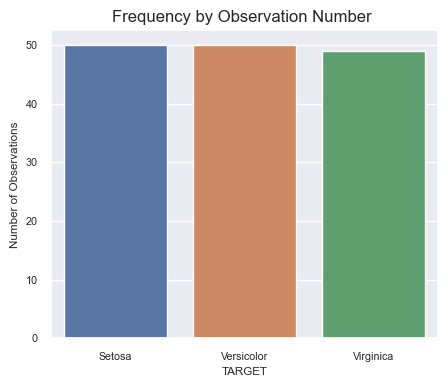

Las clases se encuentran balanceadas!


True

In [54]:
def check_imbalanced_class():
    plt.rcParams['figure.figsize'] = (5, 4)

    count_class = pd.value_counts(df[target_column], sort=True, normalize=False)
    sns.barplot(x=count_class.index, y=count_class.values)

    plt.title('Frequency by Observation Number ', fontsize=12)
    plt.ylabel('Number of Observations')
    plt.show()

    if count_class.max() > count_class.min() * 4:
        print('Las clases no se encuentran balanceadas...\nSe deben aplicar estrategias para mejorar los datos.')
        return False
    else:
        print('Las clases se encuentran balanceadas!')
        return True


check_imbalanced_class()


Se debe analizar la mejor métrica para el problema.
- https://www.juanbarrios.com/la-matriz-de-confusion-y-sus-metricas/
- https://www.aprendemachinelearning.com/clasificacion-con-datos-desbalanceados/
- https://www.diferenciador.com/diferencia-entre-exactitud-y-precision/


No changes...


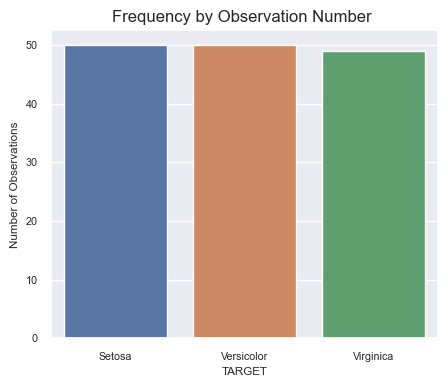

Las clases se encuentran balanceadas!


In [55]:
# ------------ Strategies: ------------
# - None
# - NearMiss(n_neighbors=3, version=2)    # under-sampling
# - RandomUnderSampler()                  # under-sampling
# - RandomOverSampler()                   # over-sampling
# - SMOTETomek()                          # Combine over- and under-sampling

resample_strategy = None


def resample(strategy, df):
    if strategy == None:
        print('No changes...')
        return df

    X, y = df.loc[:, df.columns != target_column], df[target_column]

    target_transformer = LabelEncoder()
    y = target_transformer.fit_transform(y)

    X, y = strategy.fit_resample(X, y)

    X[target_column] = target_transformer.inverse_transform(y)

    print(f'Before: {len(df)} items. After: {len(X)} items.')

    return X


df = resample(resample_strategy, df)
df_bk = df.copy()

if check_imbalanced_class() == False:
    raise ValueError('Las clases aún no se encuentran balanceadas...')


Se defnine el `target`.

In [56]:
targets = df[target_column]
targets.shape


(149,)

## Logistic Regression

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('transformer',
                                                          IrisDataTransformer(vif=False)),
                                                         ('outlier',
                                                          IrisOutlierTransformer()),
                                                         ('imputer',
                                                          IrisImputeTransformer()),
                                                         ('normality',
                                                          IrisNormalityTransformer()),
                                                         ('preprocessor',
                                                          ColumnTransformer(transformers=[('standard',
                                                                                           StandardScaler(),
                                                                                           ['SEPAL_LENGHT',
                                                                                            'SEPAL_WIDTH',
                                                                                            'PETAL_LENGHT',
                                                                                            'PETAL_WIDTH'])])),
                                                         ('polynomial',
                                                          PolynomialFeatures(degree=1)),
                                                         ('pca', PCA()),
                                                         ('model',
                                                          LogisticRegression())]),
                              target_transformer=LabelEncoder())

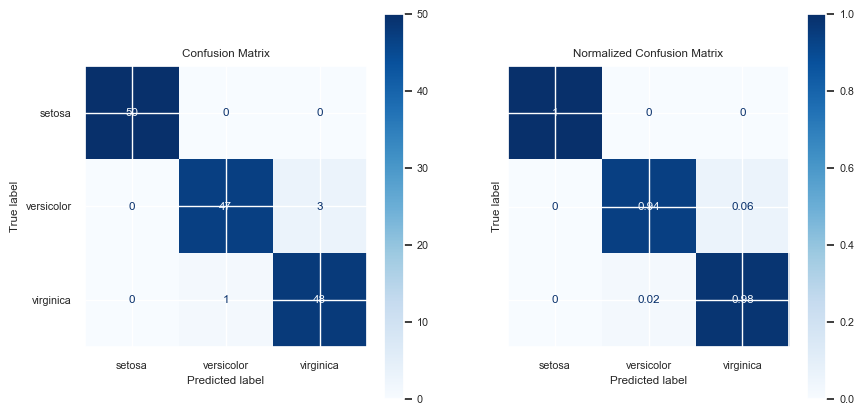

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        50
  Versicolor       0.98      0.94      0.96        50
   Virginica       0.94      0.98      0.96        49

    accuracy                           0.97       149
   macro avg       0.97      0.97      0.97       149
weighted avg       0.97      0.97      0.97       149



,TYPE,POLY_DEGREE,ACCURACY,PRECISION,RECALL,F1,ESTIMATOR
LogisticRegression,ML,1,0.9051,0.7833,0.7492,0.7628,MyTransformedTargetClassifier(classifier=Pipel...


In [57]:
clf_pd1 = my_grid_search_cv(model=LogisticRegression(), X=df, y=targets, results=results, param_grid={})


MyTransformedTargetClassifier(classifier=Pipeline(steps=[('transformer',
                                                          IrisDataTransformer(vif=False)),
                                                         ('outlier',
                                                          IrisOutlierTransformer()),
                                                         ('imputer',
                                                          IrisImputeTransformer()),
                                                         ('normality',
                                                          IrisNormalityTransformer()),
                                                         ('preprocessor',
                                                          ColumnTransformer(transformers=[('standard',
                                                                                           StandardScaler(),
                                                                                           ['SEPAL_LENGHT',
                                                                                            'SEPAL_WIDTH',
                                                                                            'PETAL_LENGHT',
                                                                                            'PETAL_WIDTH'])])),
                                                         ('polynomial',
                                                          PolynomialFeatures()),
                                                         ('pca', PCA()),
                                                         ('model',
                                                          LogisticRegression())]),
                              target_transformer=LabelEncoder())

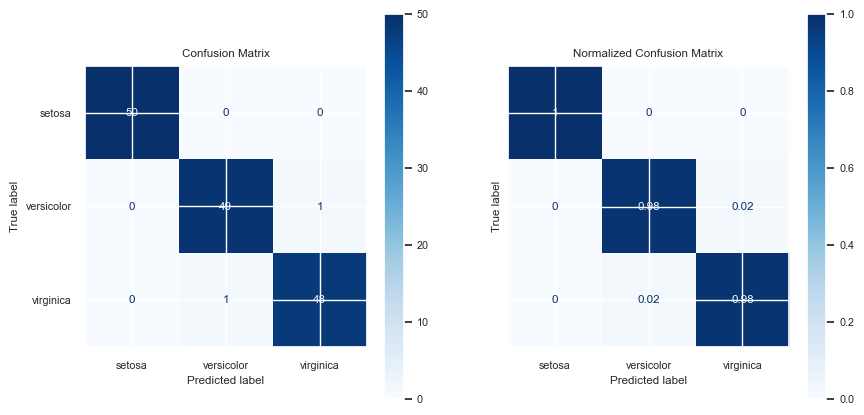

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        50
  Versicolor       0.98      0.98      0.98        50
   Virginica       0.98      0.98      0.98        49

    accuracy                           0.99       149
   macro avg       0.99      0.99      0.99       149
weighted avg       0.99      0.99      0.99       149



,TYPE,POLY_DEGREE,ACCURACY,PRECISION,RECALL,F1,ESTIMATOR
LogisticRegression,ML,1,0.9051,0.7833,0.7492,0.7628,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D2,ML,2,0.9120,0.7833,0.7526,0.7650,MyTransformedTargetClassifier(classifier=Pipel...


In [58]:
clf_pd2 = my_grid_search_cv(model=LogisticRegression(), X=df, y=targets, results=results, param_grid={}, degree=2)


MyTransformedTargetClassifier(classifier=Pipeline(steps=[('transformer',
                                                          IrisDataTransformer(vif=False)),
                                                         ('outlier',
                                                          IrisOutlierTransformer()),
                                                         ('imputer',
                                                          IrisImputeTransformer()),
                                                         ('normality',
                                                          IrisNormalityTransformer()),
                                                         ('preprocessor',
                                                          ColumnTransformer(transformers=[('standard',
                                                                                           StandardScaler(),
                                                                                           ['SEPAL_LENGHT',
                                                                                            'SEPAL_WIDTH',
                                                                                            'PETAL_LENGHT',
                                                                                            'PETAL_WIDTH'])])),
                                                         ('polynomial',
                                                          PolynomialFeatures(degree=3)),
                                                         ('pca', PCA()),
                                                         ('model',
                                                          LogisticRegression())]),
                              target_transformer=LabelEncoder())

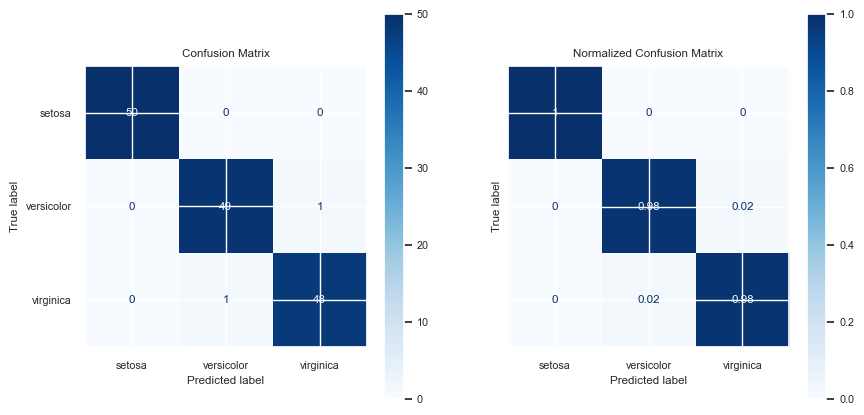

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        50
  Versicolor       0.98      0.98      0.98        50
   Virginica       0.98      0.98      0.98        49

    accuracy                           0.99       149
   macro avg       0.99      0.99      0.99       149
weighted avg       0.99      0.99      0.99       149



,TYPE,POLY_DEGREE,ACCURACY,PRECISION,RECALL,F1,ESTIMATOR
LogisticRegression,ML,1,0.9051,0.7833,0.7492,0.7628,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D2,ML,2,0.9120,0.7833,0.7526,0.7650,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D3,ML,3,0.8982,0.7833,0.7457,0.7606,MyTransformedTargetClassifier(classifier=Pipel...


In [59]:
clf_pd3 = my_grid_search_cv(model=LogisticRegression(), X=df, y=targets, results=results, param_grid={}, degree=3)


## Regularization

### Ridge

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('transformer',
                                                          IrisDataTransformer(vif=False)),
                                                         ('outlier',
                                                          IrisOutlierTransformer()),
                                                         ('imputer',
                                                          IrisImputeTransformer()),
                                                         ('normality',
                                                          IrisNormalityTransformer()),
                                                         ('preprocessor',
                                                          ColumnTransformer(transformers=[('standard',
                                                                                           StandardScaler(),
                                                                                           ['SEPAL_LENGHT',
                                                                                            'SEPAL_WIDTH',
                                                                                            'PETAL_LENGHT',
                                                                                            'PETAL_WIDTH'])])),
                                                         ('polynomial',
                                                          PolynomialFeatures(degree=1)),
                                                         ('pca', PCA()),
                                                         ('model',
                                                          RidgeClassifier(alpha=0.30000000000000004))]),
                              target_transformer=LabelEncoder())

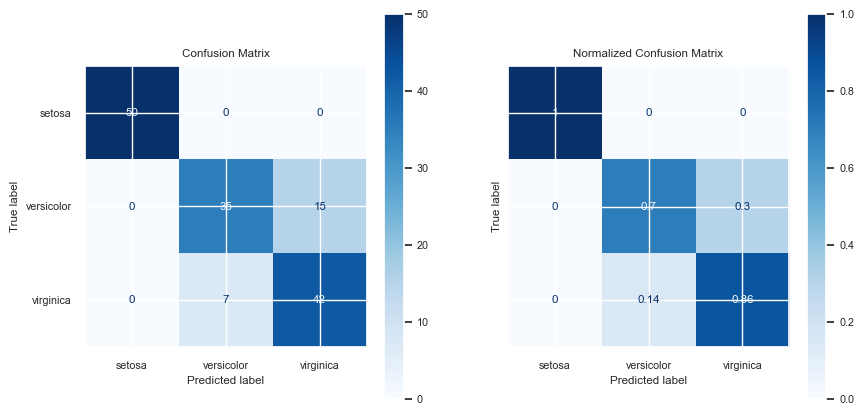

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        50
  Versicolor       0.83      0.70      0.76        50
   Virginica       0.74      0.86      0.79        49

    accuracy                           0.85       149
   macro avg       0.86      0.85      0.85       149
weighted avg       0.86      0.85      0.85       149



,TYPE,POLY_DEGREE,ACCURACY,PRECISION,RECALL,F1,ESTIMATOR
LogisticRegression,ML,1,0.9051,0.7833,0.7492,0.7628,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D2,ML,2,0.9120,0.7833,0.7526,0.7650,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D3,ML,3,0.8982,0.7833,0.7457,0.7606,MyTransformedTargetClassifier(classifier=Pipel...
RidgeClassifier,ML,1,0.6839,0.6810,0.5470,0.5755,MyTransformedTargetClassifier(classifier=Pipel...


In [60]:
param_grid = {'classifier__model__alpha': np.linspace(0.1, 1.0, 10)}
ridge = my_grid_search_cv(model=RidgeClassifier(), X=df, y=targets, results=results, param_grid=param_grid)


## Decision Trees

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('transformer',
                                                          IrisDataTransformer(vif=False)),
                                                         ('outlier',
                                                          IrisOutlierTransformer()),
                                                         ('imputer',
                                                          IrisImputeTransformer()),
                                                         ('normality',
                                                          IrisNormalityTransformer()),
                                                         ('preprocessor',
                                                          ColumnTransformer(transformers=[('standard',
                                                                                           StandardScaler(),
                                                                                           ['SEPAL_LENGHT',
                                                                                            'SEPAL_WIDTH',
                                                                                            'PETAL_LENGHT',
                                                                                            'PETAL_WIDTH'])])),
                                                         ('polynomial',
                                                          PolynomialFeatures(degree=1)),
                                                         ('pca', PCA()),
                                                         ('model',
                                                          DecisionTreeClassifier(max_depth=15))]),
                              target_transformer=LabelEncoder())

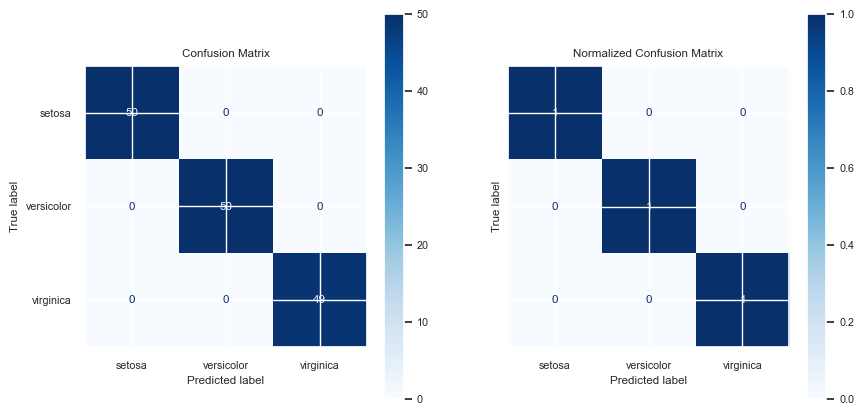

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        50
  Versicolor       1.00      1.00      1.00        50
   Virginica       1.00      1.00      1.00        49

    accuracy                           1.00       149
   macro avg       1.00      1.00      1.00       149
weighted avg       1.00      1.00      1.00       149



,TYPE,POLY_DEGREE,ACCURACY,PRECISION,RECALL,F1,ESTIMATOR
LogisticRegression,ML,1,0.9051,0.7833,0.7492,0.7628,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D2,ML,2,0.9120,0.7833,0.7526,0.7650,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D3,ML,3,0.8982,0.7833,0.7457,0.7606,MyTransformedTargetClassifier(classifier=Pipel...
RidgeClassifier,ML,1,0.6839,0.6810,0.5470,0.5755,MyTransformedTargetClassifier(classifier=Pipel...
DecisionTreeClassifier,ML,1,0.8986,0.7909,0.7476,0.7658,MyTransformedTargetClassifier(classifier=Pipel...


In [61]:
param_grid = {'classifier__model__max_depth': range(1, 20),
              'classifier__model__criterion': ['gini', 'entropy', 'log_loss']}
decision_tree_classifier = my_grid_search_cv(model=DecisionTreeClassifier(), X=df, y=targets,
                                             results=results, param_grid=param_grid)


## Support Vector Machines (SVM)

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('transformer',
                                                          IrisDataTransformer(vif=False)),
                                                         ('outlier',
                                                          IrisOutlierTransformer()),
                                                         ('imputer',
                                                          IrisImputeTransformer()),
                                                         ('normality',
                                                          IrisNormalityTransformer()),
                                                         ('preprocessor',
                                                          ColumnTransformer(transformers=[('standard',
                                                                                           StandardScaler(),
                                                                                           ['SEPAL_LENGHT',
                                                                                            'SEPAL_WIDTH',
                                                                                            'PETAL_LENGHT',
                                                                                            'PETAL_WIDTH'])])),
                                                         ('polynomial',
                                                          PolynomialFeatures(degree=1)),
                                                         ('pca', PCA()),
                                                         ('model',
                                                          SVC(C=1, gamma=0.001,
                                                              kernel='linear'))]),
                              target_transformer=LabelEncoder())

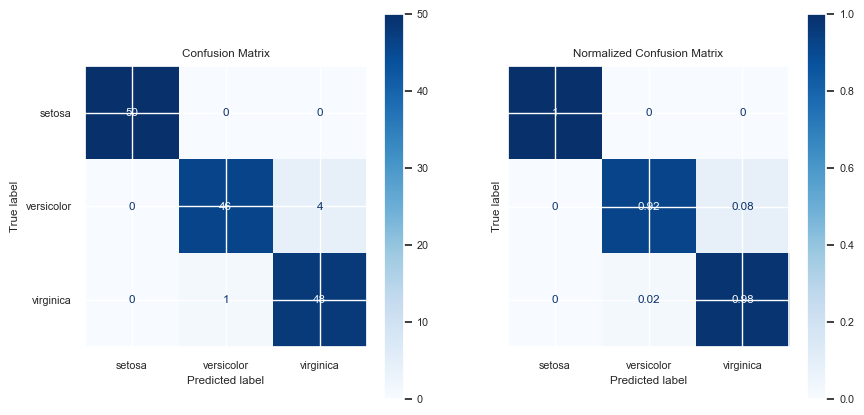

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        50
  Versicolor       0.98      0.92      0.95        50
   Virginica       0.92      0.98      0.95        49

    accuracy                           0.97       149
   macro avg       0.97      0.97      0.97       149
weighted avg       0.97      0.97      0.97       149



,TYPE,POLY_DEGREE,ACCURACY,PRECISION,RECALL,F1,ESTIMATOR
LogisticRegression,ML,1,0.9051,0.7833,0.7492,0.7628,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D2,ML,2,0.9120,0.7833,0.7526,0.7650,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D3,ML,3,0.8982,0.7833,0.7457,0.7606,MyTransformedTargetClassifier(classifier=Pipel...
RidgeClassifier,ML,1,0.6839,0.6810,0.5470,0.5755,MyTransformedTargetClassifier(classifier=Pipel...
DecisionTreeClassifier,ML,1,0.8986,0.7909,0.7476,0.7658,MyTransformedTargetClassifier(classifier=Pipel...
SVC,ML,1,0.9462,0.7909,0.7714,0.7800,MyTransformedTargetClassifier(classifier=Pipel...


In [62]:
param_grid = {'classifier__model__kernel': ['linear', 'poly', 'sigmoid', 'rbf'],  # Allows transformation to higher levels.
              # Border complexity: linear, curved.
              'classifier__model__gamma': [1e-3, 1e-2, 0.1],
              'classifier__model__C': [1, 10, 100, 1000]}  # Controls the tradeoff between training errors and hard margins.
svc = my_grid_search_cv(model=SVC(), X=df, y=targets, results=results, param_grid=param_grid)


## K Nearest Neighbors

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('transformer',
                                                          IrisDataTransformer(vif=False)),
                                                         ('outlier',
                                                          IrisOutlierTransformer()),
                                                         ('imputer',
                                                          IrisImputeTransformer()),
                                                         ('normality',
                                                          IrisNormalityTransformer()),
                                                         ('preprocessor',
                                                          ColumnTransformer(transformers=[('standard',
                                                                                           StandardScaler(),
                                                                                           ['SEPAL_LENGHT',
                                                                                            'SEPAL_WIDTH',
                                                                                            'PETAL_LENGHT',
                                                                                            'PETAL_WIDTH'])])),
                                                         ('polynomial',
                                                          PolynomialFeatures(degree=1)),
                                                         ('pca', PCA()),
                                                         ('model',
                                                          KNeighborsClassifier(metric='chebyshev',
                                                                               n_neighbors=3))]),
                              target_transformer=LabelEncoder())

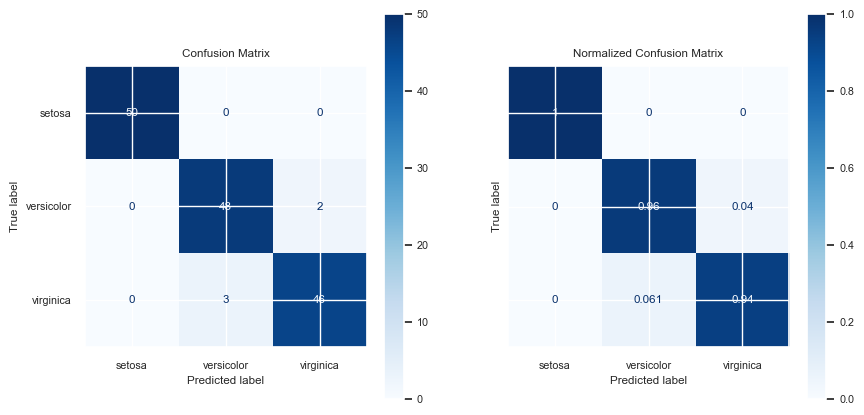

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        50
  Versicolor       0.94      0.96      0.95        50
   Virginica       0.96      0.94      0.95        49

    accuracy                           0.97       149
   macro avg       0.97      0.97      0.97       149
weighted avg       0.97      0.97      0.97       149



,TYPE,POLY_DEGREE,ACCURACY,PRECISION,RECALL,F1,ESTIMATOR
LogisticRegression,ML,1,0.9051,0.7833,0.7492,0.7628,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D2,ML,2,0.9120,0.7833,0.7526,0.7650,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D3,ML,3,0.8982,0.7833,0.7457,0.7606,MyTransformedTargetClassifier(classifier=Pipel...
RidgeClassifier,ML,1,0.6839,0.6810,0.5470,0.5755,MyTransformedTargetClassifier(classifier=Pipel...
DecisionTreeClassifier,ML,1,0.8986,0.7909,0.7476,0.7658,MyTransformedTargetClassifier(classifier=Pipel...
SVC,ML,1,0.9462,0.7909,0.7714,0.7800,MyTransformedTargetClassifier(classifier=Pipel...
KNeighborsClassifier,ML,1,0.9055,0.7833,0.7494,0.7630,MyTransformedTargetClassifier(classifier=Pipel...


In [63]:
param_grid = {'classifier__model__n_neighbors': range(3, 10, 2),
              'classifier__model__metric': ['euclidean', 'manhattan', 'chebyshev']}
k_neighbors_classifier = my_grid_search_cv(model=KNeighborsClassifier(), X=df, y=targets, results=results,
                                           param_grid=param_grid)


## Naive Bayes

### Gaussian Naive Bayes

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('transformer',
                                                          IrisDataTransformer(vif=False)),
                                                         ('outlier',
                                                          IrisOutlierTransformer()),
                                                         ('imputer',
                                                          IrisImputeTransformer()),
                                                         ('normality',
                                                          IrisNormalityTransformer()),
                                                         ('preprocessor',
                                                          ColumnTransformer(transformers=[('standard',
                                                                                           StandardScaler(),
                                                                                           ['SEPAL_LENGHT',
                                                                                            'SEPAL_WIDTH',
                                                                                            'PETAL_LENGHT',
                                                                                            'PETAL_WIDTH'])])),
                                                         ('polynomial',
                                                          PolynomialFeatures(degree=1)),
                                                         ('pca', PCA()),
                                                         ('model',
                                                          GaussianNB())]),
                              target_transformer=LabelEncoder())

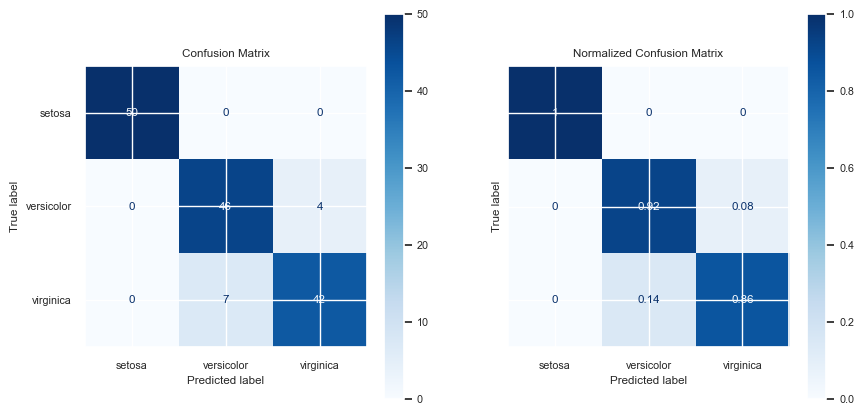

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        50
  Versicolor       0.87      0.92      0.89        50
   Virginica       0.91      0.86      0.88        49

    accuracy                           0.93       149
   macro avg       0.93      0.93      0.93       149
weighted avg       0.93      0.93      0.93       149



,TYPE,POLY_DEGREE,ACCURACY,PRECISION,RECALL,F1,ESTIMATOR
LogisticRegression,ML,1,0.9051,0.7833,0.7492,0.7628,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D2,ML,2,0.9120,0.7833,0.7526,0.7650,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D3,ML,3,0.8982,0.7833,0.7457,0.7606,MyTransformedTargetClassifier(classifier=Pipel...
RidgeClassifier,ML,1,0.6839,0.6810,0.5470,0.5755,MyTransformedTargetClassifier(classifier=Pipel...
DecisionTreeClassifier,ML,1,0.8986,0.7909,0.7476,0.7658,MyTransformedTargetClassifier(classifier=Pipel...
SVC,ML,1,0.9462,0.7909,0.7714,0.7800,MyTransformedTargetClassifier(classifier=Pipel...
KNeighborsClassifier,ML,1,0.9055,0.7833,0.7494,0.7630,MyTransformedTargetClassifier(classifier=Pipel...
GaussianNB,ML,1,0.8655,0.7048,0.6528,0.6711,MyTransformedTargetClassifier(classifier=Pipel...


In [64]:
gaussian_nb = my_grid_search_cv(model=GaussianNB(), X=df, y=targets, results=results, param_grid={})


### Multinomial Naive Bayes

In [65]:
# multinomial_nb = my_grid_search_cv(model=MultinomialNB(), X=df, y=targets, results=results, param_grid={})


### Bernoulli Naive Bayes

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('transformer',
                                                          IrisDataTransformer(vif=False)),
                                                         ('outlier',
                                                          IrisOutlierTransformer()),
                                                         ('imputer',
                                                          IrisImputeTransformer()),
                                                         ('normality',
                                                          IrisNormalityTransformer()),
                                                         ('preprocessor',
                                                          ColumnTransformer(transformers=[('standard',
                                                                                           StandardScaler(),
                                                                                           ['SEPAL_LENGHT',
                                                                                            'SEPAL_WIDTH',
                                                                                            'PETAL_LENGHT',
                                                                                            'PETAL_WIDTH'])])),
                                                         ('polynomial',
                                                          PolynomialFeatures(degree=1)),
                                                         ('pca', PCA()),
                                                         ('model',
                                                          BernoulliNB())]),
                              target_transformer=LabelEncoder())

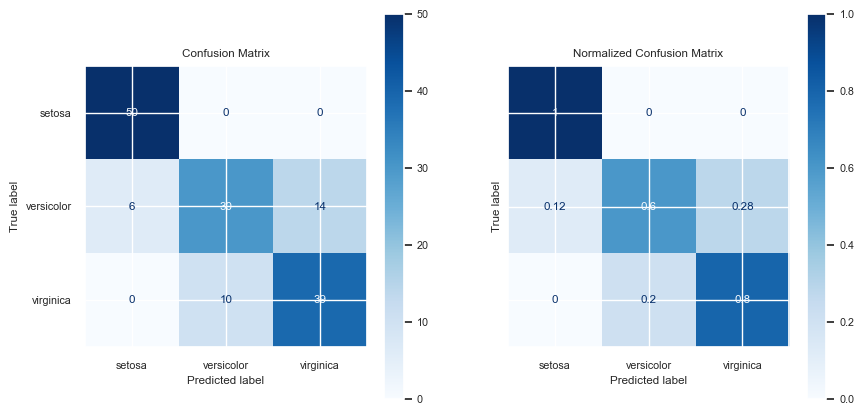

              precision    recall  f1-score   support

      Setosa       0.89      1.00      0.94        50
  Versicolor       0.75      0.60      0.67        50
   Virginica       0.74      0.80      0.76        49

    accuracy                           0.80       149
   macro avg       0.79      0.80      0.79       149
weighted avg       0.79      0.80      0.79       149



,TYPE,POLY_DEGREE,ACCURACY,PRECISION,RECALL,F1,ESTIMATOR
LogisticRegression,ML,1,0.9051,0.7833,0.7492,0.7628,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D2,ML,2,0.9120,0.7833,0.7526,0.7650,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D3,ML,3,0.8982,0.7833,0.7457,0.7606,MyTransformedTargetClassifier(classifier=Pipel...
RidgeClassifier,ML,1,0.6839,0.6810,0.5470,0.5755,MyTransformedTargetClassifier(classifier=Pipel...
DecisionTreeClassifier,ML,1,0.8986,0.7909,0.7476,0.7658,MyTransformedTargetClassifier(classifier=Pipel...
SVC,ML,1,0.9462,0.7909,0.7714,0.7800,MyTransformedTargetClassifier(classifier=Pipel...
KNeighborsClassifier,ML,1,0.9055,0.7833,0.7494,0.7630,MyTransformedTargetClassifier(classifier=Pipel...
GaussianNB,ML,1,0.8655,0.7048,0.6528,0.6711,MyTransformedTargetClassifier(classifier=Pipel...
BernoulliNB,ML,1,0.4432,0.3748,0.2616,0.2917,MyTransformedTargetClassifier(classifier=Pipel...


In [66]:
bernoulli_nb = my_grid_search_cv(model=BernoulliNB(), X=df, y=targets, results=results, param_grid={})


## Ensemble Methods

### Bagging

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('transformer',
                                                          IrisDataTransformer(vif=False)),
                                                         ('outlier',
                                                          IrisOutlierTransformer()),
                                                         ('imputer',
                                                          IrisImputeTransformer()),
                                                         ('normality',
                                                          IrisNormalityTransformer()),
                                                         ('preprocessor',
                                                          ColumnTransformer(transformers=[('standard',
                                                                                           StandardScaler(),
                                                                                           ['SEPAL_LENGHT',
                                                                                            'SEPAL_WIDTH',
                                                                                            'PETAL_LENGHT',
                                                                                            'PETAL_WIDTH'])])),
                                                         ('polynomial',
                                                          PolynomialFeatures(degree=1)),
                                                         ('pca', PCA()),
                                                         ('model',
                                                          BaggingClassifier(estimator=SVC(),
                                                                            n_estimators=3))]),
                              target_transformer=LabelEncoder())

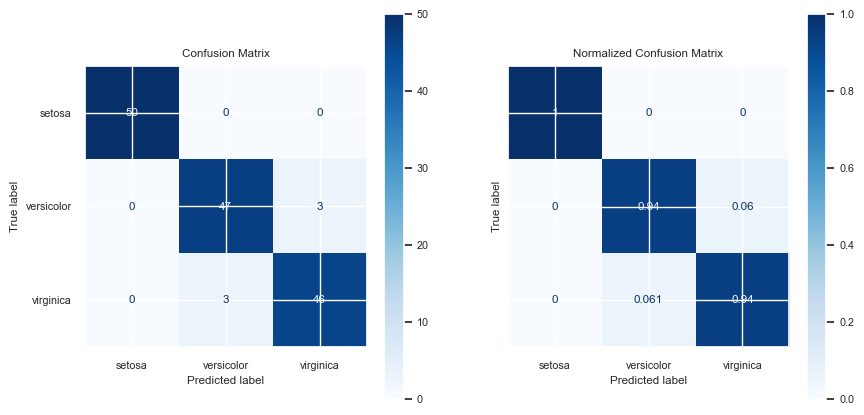

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        50
  Versicolor       0.94      0.94      0.94        50
   Virginica       0.94      0.94      0.94        49

    accuracy                           0.96       149
   macro avg       0.96      0.96      0.96       149
weighted avg       0.96      0.96      0.96       149



,TYPE,POLY_DEGREE,ACCURACY,PRECISION,RECALL,F1,ESTIMATOR
LogisticRegression,ML,1,0.9051,0.7833,0.7492,0.7628,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D2,ML,2,0.9120,0.7833,0.7526,0.7650,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D3,ML,3,0.8982,0.7833,0.7457,0.7606,MyTransformedTargetClassifier(classifier=Pipel...
RidgeClassifier,ML,1,0.6839,0.6810,0.5470,0.5755,MyTransformedTargetClassifier(classifier=Pipel...
DecisionTreeClassifier,ML,1,0.8986,0.7909,0.7476,0.7658,MyTransformedTargetClassifier(classifier=Pipel...
SVC,ML,1,0.9462,0.7909,0.7714,0.7800,MyTransformedTargetClassifier(classifier=Pipel...
KNeighborsClassifier,ML,1,0.9055,0.7833,0.7494,0.7630,MyTransformedTargetClassifier(classifier=Pipel...
GaussianNB,ML,1,0.8655,0.7048,0.6528,0.6711,MyTransformedTargetClassifier(classifier=Pipel...
BernoulliNB,ML,1,0.4432,0.3748,0.2616,0.2917,MyTransformedTargetClassifier(classifier=Pipel...
BaggingClassifier,ML,1,0.9260,0.7833,0.7597,0.7691,MyTransformedTargetClassifier(classifier=Pipel...


In [67]:
param_grid = {'classifier__model__estimator': [LogisticRegression(), GaussianProcessClassifier(),
                                               DecisionTreeClassifier(), SVC(), KNeighborsClassifier(),
                                               GaussianNB(), BernoulliNB()],
              'classifier__model__n_estimators': range(1, 21)}
bagging_classifier = my_grid_search_cv(model=BaggingClassifier(), X=df, y=targets, results=results,
                                       param_grid=param_grid)


### Boosting

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('transformer',
                                                          IrisDataTransformer(vif=False)),
                                                         ('outlier',
                                                          IrisOutlierTransformer()),
                                                         ('imputer',
                                                          IrisImputeTransformer()),
                                                         ('normality',
                                                          IrisNormalityTransformer()),
                                                         ('preprocessor',
                                                          ColumnTransformer(transformers=[('standard',
                                                                                           StandardScaler(),
                                                                                           ['SEPAL_LENGHT',
                                                                                            'SEPAL_WIDTH',
                                                                                            'PETAL_LENGHT',
                                                                                            'PETAL_WIDTH'])])),
                                                         ('polynomial',
                                                          PolynomialFeatures(degree=1)),
                                                         ('pca',
                                                          PCA(n_components=0.9)),
                                                         ('model',
                                                          AdaBoostClassifier(estimator=GaussianNB(),
                                                                             n_estimators=19))]),
                              target_transformer=LabelEncoder())

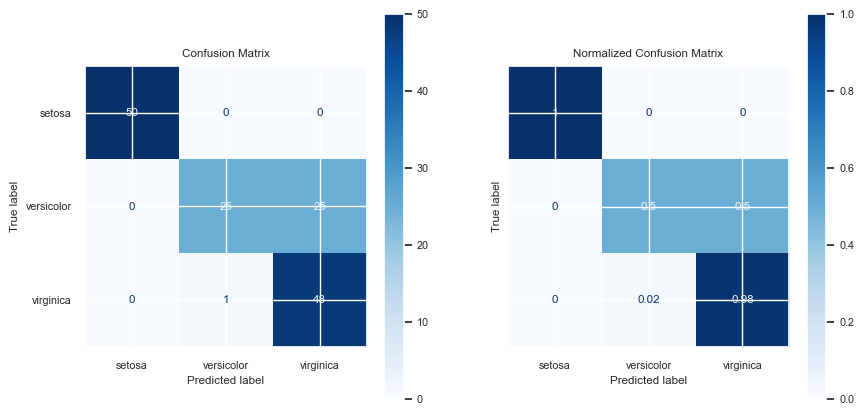

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        50
  Versicolor       0.96      0.50      0.66        50
   Virginica       0.66      0.98      0.79        49

    accuracy                           0.83       149
   macro avg       0.87      0.83      0.81       149
weighted avg       0.87      0.83      0.82       149



,TYPE,POLY_DEGREE,ACCURACY,PRECISION,RECALL,F1,ESTIMATOR
LogisticRegression,ML,1,0.9051,0.7833,0.7492,0.7628,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D2,ML,2,0.9120,0.7833,0.7526,0.7650,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D3,ML,3,0.8982,0.7833,0.7457,0.7606,MyTransformedTargetClassifier(classifier=Pipel...
RidgeClassifier,ML,1,0.6839,0.6810,0.5470,0.5755,MyTransformedTargetClassifier(classifier=Pipel...
DecisionTreeClassifier,ML,1,0.8986,0.7909,0.7476,0.7658,MyTransformedTargetClassifier(classifier=Pipel...
SVC,ML,1,0.9462,0.7909,0.7714,0.7800,MyTransformedTargetClassifier(classifier=Pipel...
KNeighborsClassifier,ML,1,0.9055,0.7833,0.7494,0.7630,MyTransformedTargetClassifier(classifier=Pipel...
GaussianNB,ML,1,0.8655,0.7048,0.6528,0.6711,MyTransformedTargetClassifier(classifier=Pipel...
BernoulliNB,ML,1,0.4432,0.3748,0.2616,0.2917,MyTransformedTargetClassifier(classifier=Pipel...
BaggingClassifier,ML,1,0.9260,0.7833,0.7597,0.7691,MyTransformedTargetClassifier(classifier=Pipel...


In [68]:
param_grid = {'classifier__model__estimator': [LogisticRegression(), DecisionTreeClassifier(),
                                               GaussianNB(), BernoulliNB()],
              'classifier__model__n_estimators': range(1, 21)}
boosting_classifier = my_grid_search_cv(model=AdaBoostClassifier(), X=df, y=targets, results=results,
                                        param_grid=param_grid)


### Gradient Boosting (GBRT)

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('transformer',
                                                          IrisDataTransformer(vif=False)),
                                                         ('outlier',
                                                          IrisOutlierTransformer()),
                                                         ('imputer',
                                                          IrisImputeTransformer()),
                                                         ('normality',
                                                          IrisNormalityTransformer()),
                                                         ('preprocessor',
                                                          ColumnTransformer(transformers=[('standard',
                                                                                           StandardScaler(),
                                                                                           ['SEPAL_LENGHT',
                                                                                            'SEPAL_WIDTH',
                                                                                            'PETAL_LENGHT',
                                                                                            'PETAL_WIDTH'])])),
                                                         ('polynomial',
                                                          PolynomialFeatures(degree=1)),
                                                         ('pca', PCA()),
                                                         ('model',
                                                          GradientBoostingClassifier(n_estimators=5))]),
                              target_transformer=LabelEncoder())

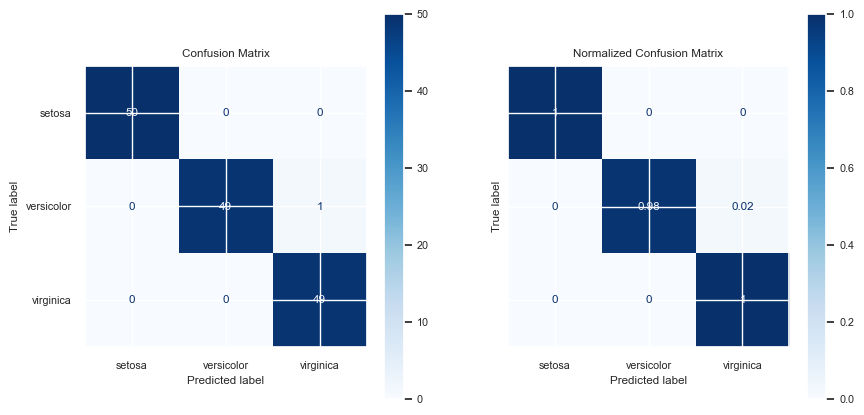

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        50
  Versicolor       1.00      0.98      0.99        50
   Virginica       0.98      1.00      0.99        49

    accuracy                           0.99       149
   macro avg       0.99      0.99      0.99       149
weighted avg       0.99      0.99      0.99       149



,TYPE,POLY_DEGREE,ACCURACY,PRECISION,RECALL,F1,ESTIMATOR
LogisticRegression,ML,1,0.9051,0.7833,0.7492,0.7628,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D2,ML,2,0.9120,0.7833,0.7526,0.7650,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D3,ML,3,0.8982,0.7833,0.7457,0.7606,MyTransformedTargetClassifier(classifier=Pipel...
RidgeClassifier,ML,1,0.6839,0.6810,0.5470,0.5755,MyTransformedTargetClassifier(classifier=Pipel...
DecisionTreeClassifier,ML,1,0.8986,0.7909,0.7476,0.7658,MyTransformedTargetClassifier(classifier=Pipel...
SVC,ML,1,0.9462,0.7909,0.7714,0.7800,MyTransformedTargetClassifier(classifier=Pipel...
KNeighborsClassifier,ML,1,0.9055,0.7833,0.7494,0.7630,MyTransformedTargetClassifier(classifier=Pipel...
GaussianNB,ML,1,0.8655,0.7048,0.6528,0.6711,MyTransformedTargetClassifier(classifier=Pipel...
BernoulliNB,ML,1,0.4432,0.3748,0.2616,0.2917,MyTransformedTargetClassifier(classifier=Pipel...
BaggingClassifier,ML,1,0.9260,0.7833,0.7597,0.7691,MyTransformedTargetClassifier(classifier=Pipel...


In [69]:
param_grid = {'classifier__model__n_estimators': range(1, 21)}
gradient_boosting_regressor = my_grid_search_cv(model=GradientBoostingClassifier(), X=df, y=targets,
                                                results=results, param_grid=param_grid)


### Random Forests

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('transformer',
                                                          IrisDataTransformer(vif=False)),
                                                         ('outlier',
                                                          IrisOutlierTransformer()),
                                                         ('imputer',
                                                          IrisImputeTransformer()),
                                                         ('normality',
                                                          IrisNormalityTransformer()),
                                                         ('preprocessor',
                                                          ColumnTransformer(transformers=[('standard',
                                                                                           StandardScaler(),
                                                                                           ['SEPAL_LENGHT',
                                                                                            'SEPAL_WIDTH',
                                                                                            'PETAL_LENGHT',
                                                                                            'PETAL_WIDTH'])])),
                                                         ('polynomial',
                                                          PolynomialFeatures(degree=1)),
                                                         ('pca', PCA()),
                                                         ('model',
                                                          RandomForestClassifier(n_estimators=7))]),
                              target_transformer=LabelEncoder())

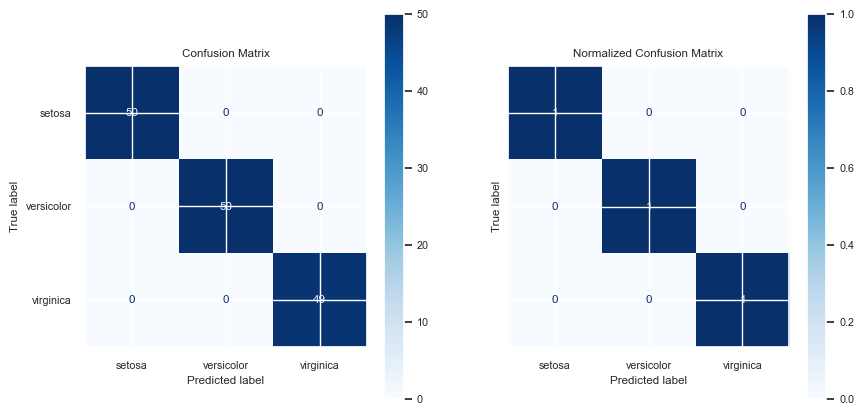

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        50
  Versicolor       1.00      1.00      1.00        50
   Virginica       1.00      1.00      1.00        49

    accuracy                           1.00       149
   macro avg       1.00      1.00      1.00       149
weighted avg       1.00      1.00      1.00       149



,TYPE,POLY_DEGREE,ACCURACY,PRECISION,RECALL,F1,ESTIMATOR
LogisticRegression,ML,1,0.9051,0.7833,0.7492,0.7628,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D2,ML,2,0.9120,0.7833,0.7526,0.7650,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D3,ML,3,0.8982,0.7833,0.7457,0.7606,MyTransformedTargetClassifier(classifier=Pipel...
RidgeClassifier,ML,1,0.6839,0.6810,0.5470,0.5755,MyTransformedTargetClassifier(classifier=Pipel...
DecisionTreeClassifier,ML,1,0.8986,0.7909,0.7476,0.7658,MyTransformedTargetClassifier(classifier=Pipel...
SVC,ML,1,0.9462,0.7909,0.7714,0.7800,MyTransformedTargetClassifier(classifier=Pipel...
KNeighborsClassifier,ML,1,0.9055,0.7833,0.7494,0.7630,MyTransformedTargetClassifier(classifier=Pipel...
GaussianNB,ML,1,0.8655,0.7048,0.6528,0.6711,MyTransformedTargetClassifier(classifier=Pipel...
BernoulliNB,ML,1,0.4432,0.3748,0.2616,0.2917,MyTransformedTargetClassifier(classifier=Pipel...
BaggingClassifier,ML,1,0.9260,0.7833,0.7597,0.7691,MyTransformedTargetClassifier(classifier=Pipel...


In [70]:
param_grid = {'classifier__model__n_estimators': range(1, 21)}
random_forest_regressor = my_grid_search_cv(model=RandomForestClassifier(), X=df, y=targets,
                                            results=results, param_grid=param_grid)


## Learning Curves

In [71]:
@interact
def _(model=results.index, results=fixed(results)):
    plt.rc('figure', figsize=(10, 6))

    train_sizes, train_scores, test_scores = learning_curve(estimator=results.loc[model].ESTIMATOR, X=df, y=targets,
                                                            cv=5, n_jobs=-1, train_sizes=np.linspace(0.5, 1., 5),
                                                            scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # display(train_sizes.shape, train_scores.shape, test_scores.shape)
    # display(train_scores_mean, test_scores_mean)

    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Traning error')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validatio error')

    plt.title(f'Learning Curves: {model}')
    plt.xlabel('Number of Samples')
    plt.ylabel('Accuracy')

    plt.legend()
    plt.show()


interactive(children=(Dropdown(description='model', options=('LogisticRegression', 'LogisticRegression_D2', 'L…

## Validation Curves

Los hiperparámetros ya fueron seleccionados en cada uno de los algoritmos mediante `GridSearchCV`.

# Deep Learning

Cuda version.

In [72]:
print(f'Tensorflow version: {tf.__version__}')

try:
    print(f"Cuda version: {build.build_info['cuda_version']}")
    print(f"Cudnn version: {build.build_info['cudnn_version']}")
except:
    print('\n GPU not enabled... \n')
    print('*****************************************************************************************')
    print('** IMPORTANT!!! If you have GPU you should run: conda install tensorflow-gpu keras-gpu **')
    print('*****************************************************************************************\n')
else:
    print('\n GPU enabled! \n')
finally:
    print(tf.config.get_visible_devices(), '\n')
    print(device_lib.list_local_devices())


Tensorflow version: 2.6.0
Cuda version: 64_113
Cudnn version: 64_8

 GPU enabled! 

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13807118475718295124
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2236245607
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2988210417803150513
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


## Tensorboard

In [73]:
# !rm -rf logs/


In [74]:
# %load_ext tensorboard
# %tensorboard --logdir logs

# if error: eliminar .tensorboard-info en C:\Users\%username%\AppData\Local\Temp


In [75]:
tensorboard = TensorBoard(os.path.join('logs', datetime.now().strftime('%Y%m%d-%H%M%S')), histogram_freq=1,
                          write_graph=True, write_images=True, update_freq='epoch', profile_batch=2, embeddings_freq=1)


## Preprocess

In [76]:
df = data_transf.fit_transform(df)
df = outlier_transf.fit_transform(df)
df = impute_transf.fit_transform(df)
df.head()


,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [77]:
preprocessor_resume = pd.DataFrame(data=df.dtypes, columns=['TYPE'])
preprocessor_resume['VALUES'] = preprocessor_resume.apply(lambda x: df[x.name].unique(), axis=1)
preprocessor_resume['VALUES_LEN'] = preprocessor_resume.apply(lambda x: len(df[x.name].unique()), axis=1)
preprocessor_resume[['TRANSFORMER', 'STATE']] = 'UNKNOWN'
# ------------------------------------------------------------------------------------------------------------------
min_max_feat = ['SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PETAL_WIDTH']
one_hot_feat = []
ordinal_feat = []

preprocessor_resume.loc[min_max_feat, 'TRANSFORMER'] = 'MIX_MAX_SCALER'
preprocessor_resume.loc[one_hot_feat, 'TRANSFORMER'] = 'ONE_HOT_ENCODER'
preprocessor_resume.loc[ordinal_feat, 'TRANSFORMER'] = 'ORDINAL_ENCODER'
# ------------------------------------------------------------------------------------------------------------------
preprocessor = ColumnTransformer(transformers=[('min_max', MinMaxScaler(feature_range=(0, 1)), min_max_feat)])

preprocessor_resume.loc[min_max_feat + one_hot_feat + ordinal_feat, 'STATE'] = 'OK'
# ------------------------------------------------------------------------------------------------------------------
X = preprocessor.fit_transform(X=df)

features_out = [f.split('__')[1] for f in preprocessor.get_feature_names_out()]
print('features_out:', ', '.join(features_out))

display(preprocessor)
display(preprocessor_resume)

print(f'Dimensiones de los datos: {X.shape}.')
input_dim = X.shape[1]
del X


features_out: SEPAL_LENGHT, SEPAL_WIDTH, PETAL_LENGHT, PETAL_WIDTH


ColumnTransformer(transformers=[('min_max', MinMaxScaler(),
                                 ['SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT',
                                  'PETAL_WIDTH'])])

,TYPE,VALUES,VALUES_LEN,TRANSFORMER,STATE
SEPAL_LENGHT,float64,"[5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.4, 4.8, 4.3, ...",35,MIX_MAX_SCALER,OK
SEPAL_WIDTH,float64,"[3.5, 3.0, 3.2, 3.1, 3.6, 3.9, 3.4, 2.9, 3.7, ...",22,MIX_MAX_SCALER,OK
PETAL_LENGHT,float64,"[1.4, 1.3, 1.5, 1.7, 1.6, 1.1, 1.2, 1.0, 1.9, ...",43,MIX_MAX_SCALER,OK
PETAL_WIDTH,float64,"[0.2, 0.4, 0.3, 0.1, 0.5, 0.6, 1.4, 1.5, 1.3, ...",22,MIX_MAX_SCALER,OK
TARGET,category,"['Setosa', 'Versicolor', 'Virginica'] Categori...",3,UNKNOWN,UNKNOWN


Dimensiones de los datos: (149, 4).


In [78]:
df = df_bk.copy()
df.head()


,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TARGET
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


## Keras - Multilayer Perceptron (MLP)

Training and test data are generated.

In [79]:
X_train, X_test, y_train, y_test = train_test_split(df, targets, test_size=0.2, shuffle=True)


In [80]:
last_units = len(iris.target_names)

if target_type == 'binary':
    last_activation = 'sigmoid'
    loss = 'binary_crossentropy'
else:
    last_activation = 'softmax'
    loss = 'categorical_crossentropy'

with tf.device('/GPU:0'):
    # Clear backend
    backend.clear_session()

    keras_model = Sequential([Dense(units=20, activation='relu', kernel_constraint=maxnorm(max_value=3),
                                    input_dim=input_dim),
                              Dropout(rate=0.2),

                              Dense(units=20, activation='relu', kernel_constraint=maxnorm(max_value=3)),
                              Dropout(rate=0.2),

                              Dense(units=last_units, activation=last_activation)])

    # https://fmorenovr.medium.com/sparse-categorical-cross-entropy-vs-categorical-cross-entropy-ea01d0392d28

    keras_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

    display(keras_model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                100       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 63        
Total params: 583
Trainable params: 583
Non-trainable params: 0
_________________________________________________________________


None

In [81]:
pipe = Pipeline(steps=[('transformer', IrisDataTransformer(vif=vif_transformer)),
                       ('outlier', IrisOutlierTransformer()),
                       ('imputer', IrisImputeTransformer()),
                       ('preprocessor', preprocessor),
                       ('model', keras_model)])

target_transformer = OneHotEncoder(sparse_output=False)

keras_estimator = MyTransformedTargetClassifier(classifier=pipe, target_transformer=target_transformer)

X_val = data_transf.fit_transform(X=X_test)
X_val = outlier_transf.fit_transform(X=X_val)
X_val = impute_transf.fit_transform(X=X_val)
X_val = preprocessor.fit_transform(X=X_val)

y_test_re = np.reshape(y_test.values, (-1, 1))
y_val = target_transformer.fit_transform(y_test_re)

keras_estimator.fit(X_train, y_train, model__batch_size=32, model__epochs=200, model__verbose=1,
                    model__shuffle=True, model__callbacks=[], model__validation_data=(X_val, y_val))


Epoch 1/200
4/4 [==============================] - 3s 134ms/step - loss: 1.1327 - accuracy: 0.3445 - val_loss: 1.1787 - val_accuracy: 0.2333
Epoch 2/200
4/4 [==============================] - 0s 17ms/step - loss: 1.1255 - accuracy: 0.4034 - val_loss: 1.1539 - val_accuracy: 0.2333
Epoch 3/200
4/4 [==============================] - 0s 18ms/step - loss: 1.0956 - accuracy: 0.3613 - val_loss: 1.1317 - val_accuracy: 0.2333
Epoch 4/200
4/4 [==============================] - 0s 17ms/step - loss: 1.0813 - accuracy: 0.3950 - val_loss: 1.1111 - val_accuracy: 0.2333
Epoch 5/200
4/4 [==============================] - 0s 17ms/step - loss: 1.1004 - accuracy: 0.3782 - val_loss: 1.0934 - val_accuracy: 0.2333
Epoch 6/200
4/4 [==============================] - 0s 18ms/step - loss: 1.0687 - accuracy: 0.3866 - val_loss: 1.0789 - val_accuracy: 0.2333
Epoch 7/200
4/4 [==============================] - 0s 17ms/step - loss: 1.0637 - accuracy: 0.3866 - val_loss: 1.0664 - val_accuracy: 0.2333
Epoch 8/200
4/4 [==

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('transformer',
                                                          IrisDataTransformer(vif=False)),
                                                         ('outlier',
                                                          IrisOutlierTransformer()),
                                                         ('imputer',
                                                          IrisImputeTransformer()),
                                                         ('preprocessor',
                                                          ColumnTransformer(transformers=[('min_max',
                                                                                           MinMaxScaler(),
                                                                                           ['SEPAL_LENGHT',
                                                                                            'SEPAL_WIDTH',
                                                                                            'PETAL_LENGHT',
                                                                                            'PETAL_WIDTH'])])),
                                                         ('model',
                                                          <keras.engine.sequential.Sequential object at 0x000001A948135AC0>)]),
                              target_transformer=OneHotEncoder(sparse_output=False))

Analyzing the training and evaluation data.

In [82]:
keras_model = keras_estimator.classifier['model']

historial_train = keras_model.history
hist = pd.DataFrame(historial_train.history)
hist['epoch'] = historial_train.epoch
hist.tail()


,loss,accuracy,val_loss,val_accuracy,epoch
195,0.213397,0.907563,0.080224,0.966667,195
196,0.179905,0.932773,0.074172,0.966667,196
197,0.149670,0.949580,0.074142,0.966667,197
198,0.178101,0.932773,0.075579,0.966667,198
199,0.145498,0.949580,0.075651,0.966667,199


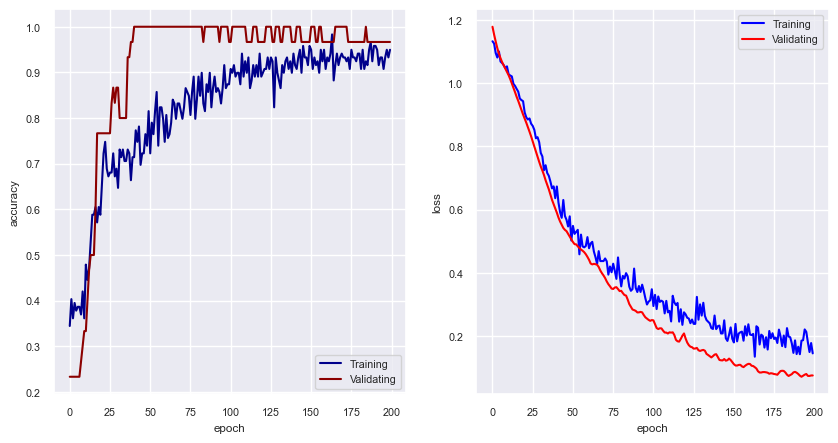

In [83]:
def plot_metrics(train):
    plt.figure(figsize=(10, 5))

    ax1 = plt.subplot(1, 2, 1)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.plot(train.history['accuracy'], color='darkblue', label='Training')
    ax1.plot(train.history['val_accuracy'], color='darkred', label='Validating')
    ax1.legend()

    ax1 = plt.subplot(1, 2, 2)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.plot(train.history['loss'], color='blue', label='Training')
    ax1.plot(train.history['val_loss'], color='red', label='Validating')
    ax1.legend()


plot_metrics(historial_train)


Model evaluation.

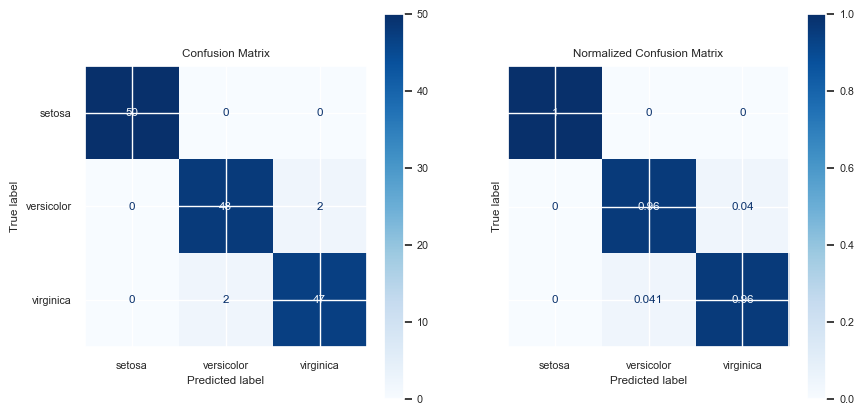

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        50
  Versicolor       0.96      0.96      0.96        50
   Virginica       0.96      0.96      0.96        49

    accuracy                           0.97       149
   macro avg       0.97      0.97      0.97       149
weighted avg       0.97      0.97      0.97       149



In [84]:
show_confusion_matrix_report(keras_estimator, df, targets)


In [85]:
y_pred = keras_estimator.predict(X=X_train)

accuracy = round(accuracy_score(y_train, y_pred), 4)
precision = round(precision_score(y_train, y_pred, average='macro'), 4)
recall = round(recall_score(y_train, y_pred, average='macro'), 4)
f1 = round(f1_score(y_train, y_pred, average='macro'), 4)

results.loc['Keras (MLP)'] = {'TYPE': 'DL', 'POLY_DEGREE': None,
                              'ACCURACY': accuracy, 'PRECISION': precision, 'RECALL': recall, 'F1': f1,
                              'ESTIMATOR': keras_estimator}
results


,TYPE,POLY_DEGREE,ACCURACY,PRECISION,RECALL,F1,ESTIMATOR
LogisticRegression,ML,1,0.9051,0.7833,0.7492,0.7628,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D2,ML,2,0.9120,0.7833,0.7526,0.7650,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D3,ML,3,0.8982,0.7833,0.7457,0.7606,MyTransformedTargetClassifier(classifier=Pipel...
RidgeClassifier,ML,1,0.6839,0.6810,0.5470,0.5755,MyTransformedTargetClassifier(classifier=Pipel...
DecisionTreeClassifier,ML,1,0.8986,0.7909,0.7476,0.7658,MyTransformedTargetClassifier(classifier=Pipel...
SVC,ML,1,0.9462,0.7909,0.7714,0.7800,MyTransformedTargetClassifier(classifier=Pipel...
KNeighborsClassifier,ML,1,0.9055,0.7833,0.7494,0.7630,MyTransformedTargetClassifier(classifier=Pipel...
GaussianNB,ML,1,0.8655,0.7048,0.6528,0.6711,MyTransformedTargetClassifier(classifier=Pipel...
BernoulliNB,ML,1,0.4432,0.3748,0.2616,0.2917,MyTransformedTargetClassifier(classifier=Pipel...
BaggingClassifier,ML,1,0.9260,0.7833,0.7597,0.7691,MyTransformedTargetClassifier(classifier=Pipel...


# Conclusions

Se ordenan los resultados según el `score` seleccionado en la validación cruzada.

In [86]:
results_sort = results.sort_values(by=['ACCURACY'], ascending=[False])
results_sort


,TYPE,POLY_DEGREE,ACCURACY,PRECISION,RECALL,F1,ESTIMATOR
Keras (MLP),DL,None,0.9748,0.9730,0.9747,0.9737,MyTransformedTargetClassifier(classifier=Pipel...
SVC,ML,1,0.9462,0.7909,0.7714,0.7800,MyTransformedTargetClassifier(classifier=Pipel...
BaggingClassifier,ML,1,0.9260,0.7833,0.7597,0.7691,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression_D2,ML,2,0.9120,0.7833,0.7526,0.7650,MyTransformedTargetClassifier(classifier=Pipel...
AdaBoostClassifier,ML,1,0.9067,0.8242,0.7717,0.7917,MyTransformedTargetClassifier(classifier=Pipel...
KNeighborsClassifier,ML,1,0.9055,0.7833,0.7494,0.7630,MyTransformedTargetClassifier(classifier=Pipel...
LogisticRegression,ML,1,0.9051,0.7833,0.7492,0.7628,MyTransformedTargetClassifier(classifier=Pipel...
DecisionTreeClassifier,ML,1,0.8986,0.7909,0.7476,0.7658,MyTransformedTargetClassifier(classifier=Pipel...
RandomForestClassifier,ML,1,0.8986,0.7833,0.7460,0.7609,MyTransformedTargetClassifier(classifier=Pipel...
GradientBoostingClassifier,ML,1,0.8984,0.7576,0.7220,0.7368,MyTransformedTargetClassifier(classifier=Pipel...


<Axes: >

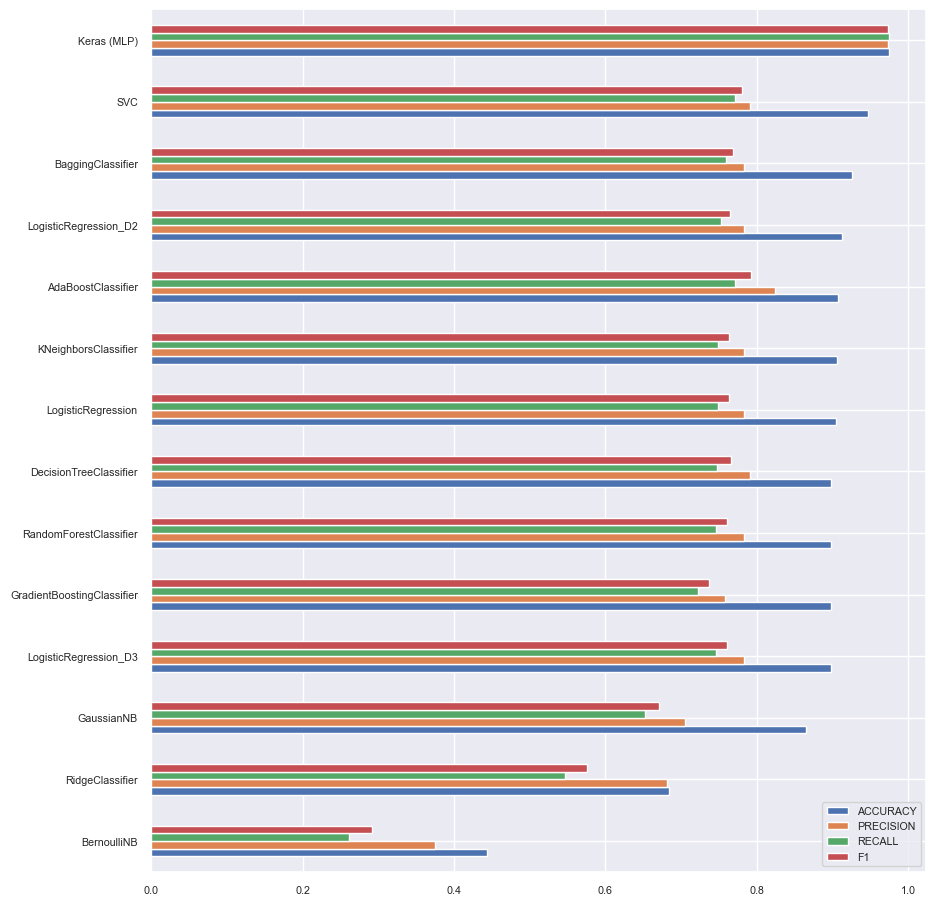

In [87]:
plt.rc('figure', figsize=(10, results_sort.shape[0]*.8))
results_sort.drop(labels='POLY_DEGREE', axis=1, inplace=True)
results_sort[::-1].plot.barh(rot=0)


In [88]:
print(f'Best tentative algorithm "{results_sort.iloc[0].name}" with ACCURACY={results_sort.iloc[0].ACCURACY}.')


Best tentative algorithm "Keras (MLP)" with ACCURACY=0.9748.


In [89]:
best_sklearn_model = results_sort[results_sort.TYPE == 'ML'].iloc[0].ESTIMATOR
best_keras_model = results_sort[results_sort.TYPE == 'DL'].iloc[0].ESTIMATOR


## Export

Save to file.

In [90]:
sklearn_model_filename = 'resources/sklearn_model.pkl'
keras_model_folder = 'resources/keras_model'

pickle.dump(best_sklearn_model, open(sklearn_model_filename, 'wb'))
best_keras_model.save(keras_model_folder)


Load from file.

In [91]:
sklearn_model_loaded = pickle.load(open(sklearn_model_filename, 'rb'))
keras_model_loaded = MyTransformedTargetClassifier.load(keras_model_folder)

display(sklearn_model_loaded, keras_model_loaded)


MyTransformedTargetClassifier(classifier=Pipeline(steps=[('transformer',
                                                          IrisDataTransformer(vif=False)),
                                                         ('outlier',
                                                          IrisOutlierTransformer()),
                                                         ('imputer',
                                                          IrisImputeTransformer()),
                                                         ('normality',
                                                          IrisNormalityTransformer()),
                                                         ('preprocessor',
                                                          ColumnTransformer(transformers=[('standard',
                                                                                           StandardScaler(),
                                                                                           ['SEPAL_LENGHT',
                                                                                            'SEPAL_WIDTH',
                                                                                            'PETAL_LENGHT',
                                                                                            'PETAL_WIDTH'])])),
                                                         ('polynomial',
                                                          PolynomialFeatures(degree=1)),
                                                         ('pca', PCA()),
                                                         ('model',
                                                          SVC(C=1, gamma=0.001,
                                                              kernel='linear'))]),
                              target_transformer=LabelEncoder())

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('transformer',
                                                          IrisDataTransformer(vif=False)),
                                                         ('outlier',
                                                          IrisOutlierTransformer()),
                                                         ('imputer',
                                                          IrisImputeTransformer()),
                                                         ('preprocessor',
                                                          ColumnTransformer(transformers=[('min_max',
                                                                                           MinMaxScaler(),
                                                                                           ['SEPAL_LENGHT',
                                                                                            'SEPAL_WIDTH',
                                                                                            'PETAL_LENGHT',
                                                                                            'PETAL_WIDTH'])])),
                                                         ('model',
                                                          <keras.engine.sequential.Sequential object at 0x000001A9499A9580>)]),
                              target_transformer=OneHotEncoder(sparse_output=False))

## Predict

In [92]:
_X = df.sample(20)
# _X = df[:20]

pred_df = pd.DataFrame(data={'REAL': _X[target_column],
                             'SKLEARN_PRED': sklearn_model_loaded.predict(X=_X),
                             'KERAS_PRED': keras_model_loaded.predict(X=_X)})

pred_df


,REAL,SKLEARN_PRED,KERAS_PRED
27,Setosa,Setosa,Setosa
108,Virginica,Virginica,Virginica
87,Versicolor,Versicolor,Versicolor
101,Virginica,Virginica,Virginica
13,Setosa,Setosa,Setosa
37,Setosa,Setosa,Setosa
135,Virginica,Virginica,Virginica
23,Setosa,Setosa,Setosa
20,Setosa,Setosa,Setosa
34,Setosa,Setosa,Setosa


## Summary

- Se obtuvieron conclusiones mediante el `análisis exploratorio de datos` los cuales ayudaron a:
    - Entender gráficamente los datos.
    - Agrupar los datos numéricos en categóricos para su análisis.
    - Analizar la correlación entre los datos.
    - Observar las distribuciones de los datos.
    - Analizar las relaciones entre las variables categóricas mediante la tabla de contingencia.
    - Obtener conclusiones sobre los datos numéricos.
- Se realizaron `test de normalidad` a los datos y sus posibles transformaciones.
- Se aplicó un `preprocesado de los datos` para la estandarización o normalización de los datos y las transformaciones de los datos categóricos a numéricos.
- Se analizaron los posibles `datos desbalanceados` y se mitigaron mediante diferentes técnicas.
- Se obtuvieron `14 modelos`, 13 de Machine Learning y 1 de Deep Learning.
- Cada modelo fué `ajustado` con los mejores parámetros utilizando además `validación cruzada`.
- En los modelos obtenidos se calcularon 4 estadísticos (`Exactitud, Precisión, Sensibilidad y F1`).
- De los estadísticos utilizados se decidió la `exactitud` tanto para ajustar el modelo como para seleccionar el mejor,
 ya que las clases se encuentran `correctamente balanceadas`. Caso contrario se debía utilizar estadístiicos como 
 la `sensibilidad` o `F1`.
- Se exporta el mejor modelo de `Machine Learning` y el de `Deep Learning` para su posterior despliegue ya sea utilizando 
microservicios u otra alternativa.